Authors: Jimena Gonzalez & Gillian Cartwright

In [1]:
script = False
cluster = False

In [2]:
# general
import numpy as np
import pandas as pd
import random
import os
import gc

# images & plotting
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

# albumentations transformations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# loading bar
if(script):
    from tqdm import tqdm
else: 
    from tqdm.notebook import tqdm

plt.style.use('dark_background')

## Preprocessing
### Training Set Functions:

In [3]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Args:
        * seed {int}: number of the seed
    Returns: void
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
class ImageDataset(Dataset):
    """
    PyTorch dataset of Images, Data and Labels
    Args:
        * images {(N, channels, pix, pix) array}: images for dataset
        * data {pandas dataframe}: data for images
        * labels {(N, classes, pix, pix) array}: labels/masks for images
        * mode {str}: 'Train' or 'Test'
        * transform: composed albumentations augmentations to be applied
                     to training images
        * resize: composed albumentations augmentation to resize images
                  and masks to correct size (96, 96) & tensor
    Returns: Pytorch dataset
    """

    def __init__(self, images, data, labels, mode=None, transform=None, resize=None):
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.mode = mode
        self.transform = transform
        self.resize = resize

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]  # get image
        image = self.normalize(img)
        label = self.labels[idx]  # get label
        data_point = self.data.iloc[idx].to_dict()  # get data

        # transpose to appropriate dimensions
        image = image.transpose(1, 2, 0)  # (pix, pix, channels)
        label = label.transpose(1, 2, 0)  # (pix, pix, classes)

        # transform
        if self.transform is not None:
            image = image.astype(np.float32)
            transformed = self.transform(image=image, mask=label)
            image = transformed['image']
            label = transformed['mask']

        # resizing transformation
        resized = self.resize(image=image, mask=label)
        image = resized['image']
        label = resized['mask']
        
        # return item
        return {'image': image, 'label': label, 'img': img, 'data': data_point}

    def normalize(self, image):
        """
        Normalize image between 0 and 1 using min and max
        Args:
        * image: (3, pix, pix) numpy array
        Returns: normalized image in original size
        """
        normed = np.empty(image.shape)  # break
        MIN = np.min(image)
        MAX = np.max(image)
        for band in range(3):
            flat = image[band].flatten(order='C')
            for i in range(len(flat)):
                flat[i] = (flat[i]-MIN)/(MAX-MIN)

            normed[band] = np.reshape(flat, image[0].shape, order='C')

        return normed



In [5]:
def make_train_test_datasets(images, data, labels, test_size, transform=None, resize=None):
    """
    Make two datasets
    Args:
        * images {(N, channels, pix, pix) array}: all images
        * data {pandas dataframe}: data from fits file
        * labels {(N, classes, pix, pix) array}: all masks/labels
        * test_size {float}: the fraction of the images to use as the test dataset
        * transform: albumentations transformations to apply to training dataset
        * resize: albumentations transform to resize (h, w) from (45, 45) to (96, 96)
    Returns
        * train_dataset: An instance of the ImageDataset Class for training
        * test_dataset: An instance of the ImageDataset Class for testing
    """

    # Shuffle and split data
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6)
    
    # Create PyTorch Datasets
    return (ImageDataset(train_images, train_data, train_labels, transform=augs, resize=resize_transform),
            ImageDataset(test_images, test_data, test_labels, transform=None, resize=resize_transform))

In [6]:
def show_training_set(train_dataset, idx):
    """
    Plot training dataset with transformations for visualization
    Args:
        * train_dataset: instance of ImageDataset for training
    Returns: void
    """
    sample = train_dataset[idx]
    orig, train, label = sample['img'], sample['image'], sample['label']

    # set up figure
    loc = plticker.MultipleLocator(base=3.75)
    fig, ax = plt.subplots(figsize=(15, 4), ncols=3)
    
    # original image
    orig_rgb = make_lupton_rgb(orig[2], orig[1], orig[0], Q=11., stretch=40.)
    ax[0].set_title('Original Image')
    ax[0].xaxis.set_ticklabels([])
    ax[0].yaxis.set_ticklabels([])
    ax[0].imshow(orig_rgb, aspect='equal')

    # transformed image
    new_rgb = make_lupton_rgb(train[2], train[1], train[0], stretch=.5, Q=4.)
    ax[1].set_title('Transformed Image')
    ax[1].xaxis.set_ticklabels([])
    ax[1].yaxis.set_ticklabels([])
    ax[1].imshow(new_rgb, aspect='equal')

    # training image (also transformed)
    ax[2].set_title('Training Label')
    ax[2].imshow(label[:, :, 1], interpolation='nearest', cmap='copper')  # lens
    ax[2].imshow(label[:, :, 0], alpha=0.5, interpolation='bilinear', cmap='bone')  # source
    ax[2].axis('off')

    if not script:
        plt.show()
        plt.close()

### Make Training Set

In [7]:
# set seeds
seed_everything(9)

# set path name
if cluster:
    path = '/home/gcartwright/Segmentation/Image_Segmentation/' # OSG home
else:
    path = '/Users/gilliancartwright/Desktop/Research/Segmentation/Image-Segmentation/' # local

npos = 1000  # number of images TESTING
num_workers = 0  # number of available CPUs
num_epochs = 8  # number of epochs TESTING
num_classes = 2

# get data from fits file
hdu_list = fits.open(path + '2-45-45-TEST.fits')
idx = random.sample(range(npos), npos)  # TESTING (using all test data available)
images = hdu_list[1].data[idx,:].astype(np.float32)
labels = hdu_list[4].data[idx,:].astype(np.float32)
data = pd.DataFrame(hdu_list[7].data[:][idx])
data = data.drop('TILENAME', axis=1)
hdu_list.close()

# check that data was loaded successfully
print(images.shape, labels.shape)

(1000, 3, 45, 45) (1000, 2, 45, 45)


In [8]:
NUM_PIX = 45  # number of pixels per axis

# Transformations
augs = A.Compose([
       A.OneOf([A.ElasticTransform(alpha = NUM_PIX*0.03, sigma = NUM_PIX*0.3, alpha_affine =NUM_PIX*0.1),
                A.GridDistortion(num_steps=5, distort_limit=0.3),
                A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05)], p=0.25)])

resize_transform = A.Compose([A.Resize(96, 96), ToTensorV2()])

In [9]:
# split data into train and valid/test
train_dataset, other_dataset = make_train_test_datasets(images, data, labels, test_size=0.2,
                                                        transform=augs, resize=resize_transform)
# split valid/test dataset into validate and test
valid_dataset, test_dataset = make_train_test_datasets(other_dataset.images, other_dataset.data,
                                                       other_dataset.labels, test_size=0.5,
                                                       transform=None, resize=resize_transform)
# check datasets
print('Len train dataset: {}, len test dataset: {}'.format(len(train_dataset), len(test_dataset)))

Len train dataset: 800, len test dataset: 100


In [10]:
# set up dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=5,
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=5,
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1,
                                          num_workers=num_workers, shuffle=True)
torch.save(test_loader, 'test_loader.pth')

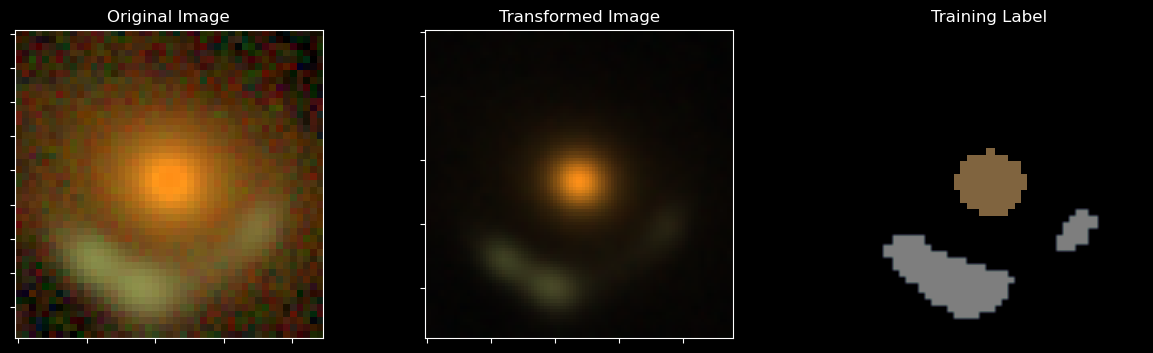

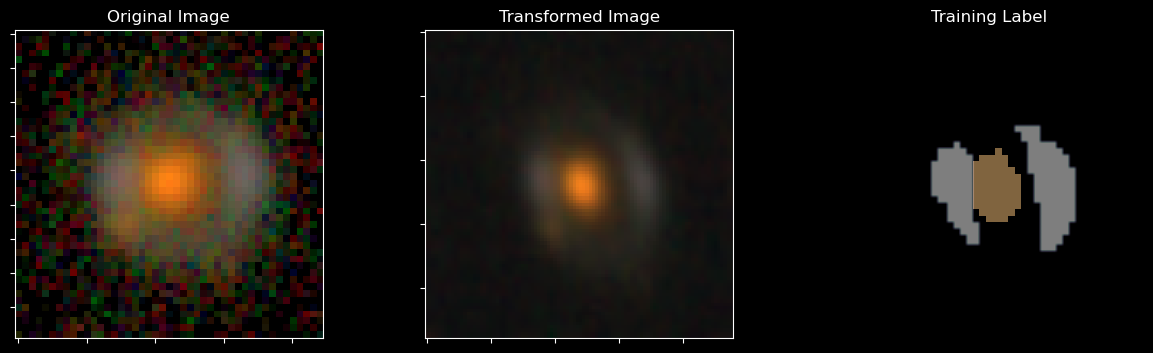

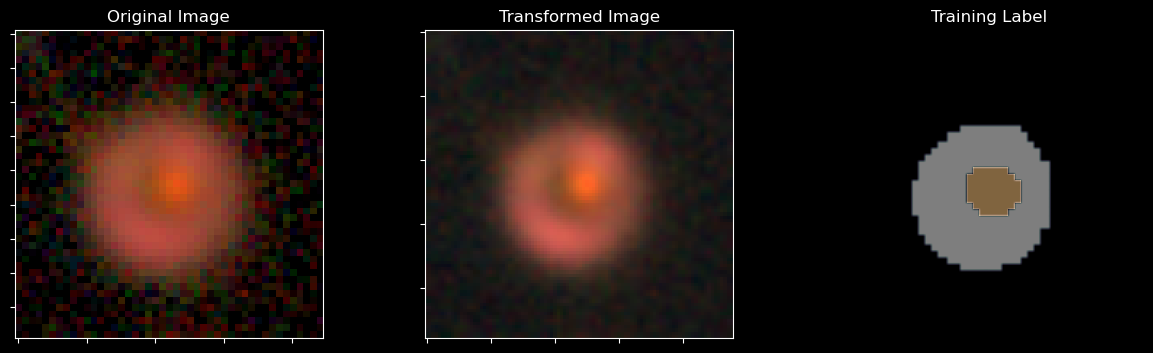

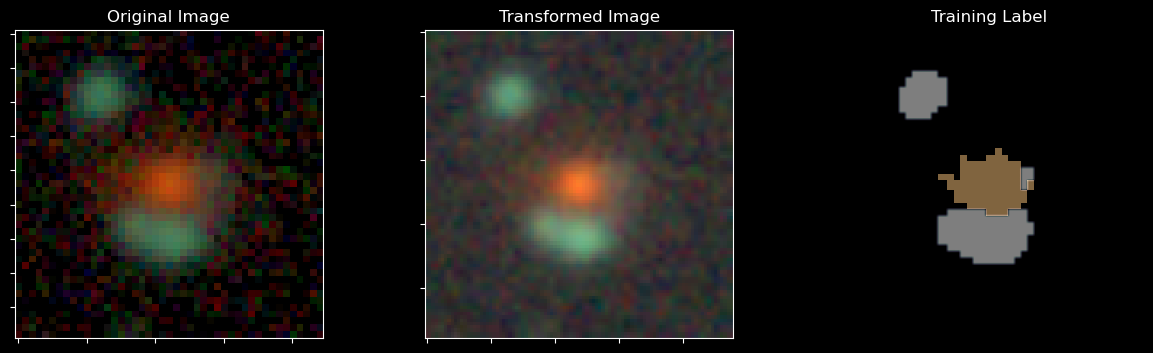

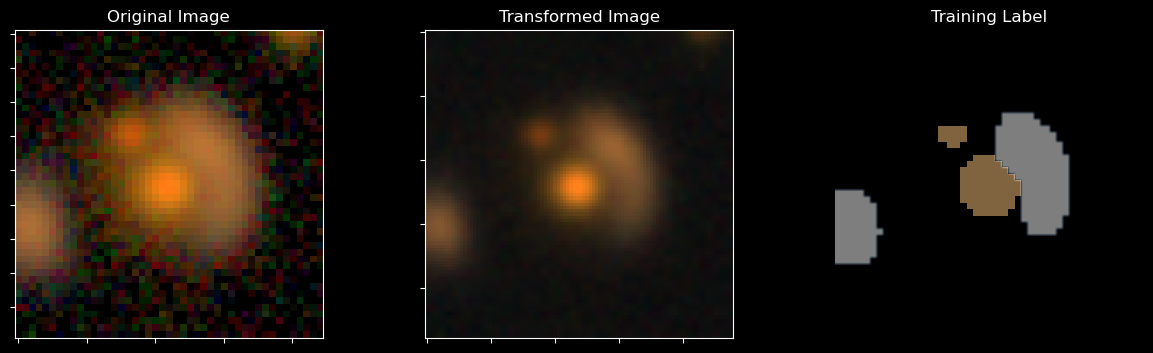

In [11]:
for idx in range(5):
    show_training_set(train_dataset, idx)

## Segmentation
### Creating the model

In [12]:
class UNet(nn.Module):
    """
    U-Net model
    """
    def __init__(self, classes, pretrained=False): 
        super(UNet, self).__init__()

        if(not cluster):
            self.model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet",
                                  in_channels=3, classes=classes)
            torch.save(self.model.state_dict(), 'initial_model.pt')

        else:
            self.model = smp.Unet(encoder_name="resnet50", in_channels=3, classes=classes)
            self.model.load_state_dict(torch.load('initial_model.pt'))


    def forward(self, x):
        """
        compute predicted outputs by passing inputs to the model
        """
        x = self.model(x)
        return x


    def pseudo_accuracy(self, output, target):
        """
        get pixel accuracy
        """
        tp, fp, fn, tn = smp.metrics.get_stats(output, target.long(),
                                               mode='multilabel',
                                               threshold=0.5)
        return smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")


    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        """
        train the model
        """
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        self.model.train()

        for i, sample in enumerate(tqdm(train_loader)):
            data = sample['image']
            target = sample['label'].permute(0, 3, 1, 2)  # reshape to match data
            sample_img = sample['img']
            sample_data = sample['data']

            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass
            output = self.forward(data)

            # calculate the batch loss
            loss = criterion(output, target.long())

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calculate Accuracy
            accuracy = self.pseudo_accuracy(output, target)

            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy
            optimizer.step()

        return epoch_loss / len(train_loader.dataset), epoch_accuracy / len(train_loader)


    def validate_one_epoch(self, valid_loader, criterion, device):
        """
        validate the model
        """
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        self.model.eval()
        for i, sample in enumerate(tqdm(valid_loader)):
            data = sample['image']
            target = sample['label'].permute(0, 3, 1, 2)
            sample_img = sample['img']
            sample_data = sample['data']

            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)

                # calculate the batch loss
                loss = criterion(output, target.long())

                # Calculate Accuracy
                accuracy = self.pseudo_accuracy(output, target)

                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader.dataset), valid_accuracy / len(valid_loader)



### Functions to train the model & visualize results

In [13]:
def fit_tpu(model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    """
    Train the model (fit tensor processing units)
    Args:
        * model {torch.nn.Module}: U-Net model
        * name_model {str}: name to save model under
        * epochs {int}: num_epochs
        * device {torch.device}: cpu or gpu
        * criterion {}: Jaccard loss
        * optimizer {}: Adam optimizer
        * train_loader: dataloader for training dataset
        * valid_loader: dataloader for validation dataset
    Returns: void
    """
    best_val_acc = 0.0 # track of best accuracy

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    # train
    for epoch in range(1, epochs + 1):
        gc.collect()
        print(f"{'=' * 100}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        # moves towards valid_loader
        print("start valid_loader")

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            # update losses
            if(valid_acc > best_val_acc):
                setattr(model, 'loss_train', train_losses)
                setattr(model, 'loss_valid', valid_losses)
                setattr(model, 'train_acc', train_accs)
                setattr(model, 'validation_acc', valid_accs)
                torch.save(model, name_model)
                best_val_acc = valid_acc



In [14]:
def plot_performance(model):
    """
    Plot loss and accuracy vs. epoch
    Args:
        * model: trained model
    """
    loss_train = [x.item() for x in model.loss_train]
    loss_valid = [x.item() for x in model.loss_valid]
    train_acc = [x.item() for x in model.train_acc]
    valid_acc = [x.item() for x in model.validation_acc]
    
    x = np.linspace(1, len(model.loss_train), len(model.loss_train))
    fig, ax = plt.subplots(figsize=(16, 7), ncols=2)

    ax[0].set_title('Losses')
    ax[0].set_xlabel('Epoch')
    ax[0].scatter(x, loss_train, color='skyblue', alpha=0.8, label='Training loss')
    ax[0].scatter(x, loss_valid, color='limegreen', alpha=0.8,  label='Validation loss')
    ax[0].legend()
    
    ax[1].set_title('Performance. Max: {:.4f}%'.format(100*model.validation_acc[-1].item()))
    ax[1].set_xlabel('Epoch')
    ax[1].scatter(x, train_acc, color='skyblue', alpha=0.8,  label='Training Accuracy')
    ax[1].scatter(x, valid_acc, color='limegreen', alpha=0.8,  label='Validation Accuracy')
    ax[1].legend()
    
    if(script):
        plt.savefig('Performance.png', bbox_inches='tight')
        plt.close()
    else: 
        plt.show(block=True)



In [15]:
def make_graphs(name, image, label, pred_label):
    loc = plticker.MultipleLocator(base=3.75)
    fig, ax = plt.subplots(figsize=(15, 4), ncols=3)

    rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[0].imshow(rgb, aspect='equal')

    ax[1].set_title('True Label')
    ax[1].axis('off')
    ax[1].imshow(label[:, :, 1], interpolation='nearest', cmap='copper')  # lens
    ax[1].imshow(label[:, :, 0], alpha=0.5, interpolation='bilinear', cmap='bone')  # source

    ax[2].set_title('Pred Label')
    ax[2].axis('off')
    ax[2].imshow(pred_label.detach().numpy()[1, :, :],
                 interpolation='nearest', cmap='copper')  # lens

    ax[2].imshow(pred_label.detach().numpy()[0, :, :],
                 alpha=0.5, interpolation='bilinear', cmap='bone')  # source

#     plt.savefig(sub_path + 'Data/Sim_complete/Image' + name + '.png', bbox_inches='tight')
    plt.show()

In [16]:
def testing_analysis(accu_lim, test_loader):
    model.double()
    for i_batch, sample in enumerate(tqdm(test_loader)):
        if(i_batch == 100): break
        sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'], sample['img'], sample['data']

        if device.type == "cuda":
            sample_image, sample_label = sample_image.cuda(), sample_label.cuda()

        output = model(sample_image)
        output = torch.sigmoid(output)

        if(not cluster):
            sample_img = sample_img[0]
            make_graphs('name', sample_img, sample_label[0], output[0])



### Creating model, training, and testing

In [17]:
# create model and set loss mode
model = UNet(classes=num_classes, pretrained=True)
criterion = smp.losses.JaccardLoss(mode='multilabel', classes=num_classes)

# check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# set learning and optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cpu


In [18]:
name_model = 'model.pt'
if not cluster:
    from memory_profiler import memory_usage
    mem_usage = memory_usage((fit_tpu, (model, name_model, num_epochs,
                                        device, criterion, optimizer, 
                                        train_loader, valid_loader)))
    print(f'Maximum memory usage: {max(mem_usage)}')

else:
    fit_tpu(model, name_model, num_epochs, device, criterion, optimizer, train_loader, valid_loader)

EPOCH 1 - TRAINING...


  0%|          | 0/160 [00:00<?, ?it/s]


	[TRAIN] EPOCH 1 - LOSS: 0.16286882758140564, ACCURACY: 0.9036433100700378

start valid_loader
EPOCH 1 - VALIDATING...


  0%|          | 0/20 [00:00<?, ?it/s]

	[VALID] LOSS: 0.14855988323688507, ACCURACY: 0.9380344152450562

EPOCH 2 - TRAINING...


  0%|          | 0/160 [00:00<?, ?it/s]


	[TRAIN] EPOCH 2 - LOSS: 0.12795837223529816, ACCURACY: 0.960726261138916

start valid_loader
EPOCH 2 - VALIDATING...


  0%|          | 0/20 [00:00<?, ?it/s]

	[VALID] LOSS: 0.10766012966632843, ACCURACY: 0.9688698649406433

EPOCH 3 - TRAINING...


  0%|          | 0/160 [00:00<?, ?it/s]


	[TRAIN] EPOCH 3 - LOSS: 0.08554891496896744, ACCURACY: 0.9721738696098328

start valid_loader
EPOCH 3 - VALIDATING...


  0%|          | 0/20 [00:00<?, ?it/s]

	[VALID] LOSS: 0.07471276819705963, ACCURACY: 0.9720355868339539

EPOCH 4 - TRAINING...


  0%|          | 0/160 [00:00<?, ?it/s]


	[TRAIN] EPOCH 4 - LOSS: 0.0630415678024292, ACCURACY: 0.9755215644836426

start valid_loader
EPOCH 4 - VALIDATING...


  0%|          | 0/20 [00:00<?, ?it/s]

	[VALID] LOSS: 0.06199634075164795, ACCURACY: 0.9722021222114563

EPOCH 5 - TRAINING...


  0%|          | 0/160 [00:00<?, ?it/s]


	[TRAIN] EPOCH 5 - LOSS: 0.05502645671367645, ACCURACY: 0.9761832356452942

start valid_loader
EPOCH 5 - VALIDATING...


  0%|          | 0/20 [00:00<?, ?it/s]

	[VALID] LOSS: 0.059506941586732864, ACCURACY: 0.9734982252120972

EPOCH 6 - TRAINING...


  0%|          | 0/160 [00:00<?, ?it/s]


	[TRAIN] EPOCH 6 - LOSS: 0.04935840144753456, ACCURACY: 0.9779658317565918

start valid_loader
EPOCH 6 - VALIDATING...


  0%|          | 0/20 [00:00<?, ?it/s]

	[VALID] LOSS: 0.054899655282497406, ACCURACY: 0.9753504991531372

EPOCH 7 - TRAINING...


  0%|          | 0/160 [00:00<?, ?it/s]


	[TRAIN] EPOCH 7 - LOSS: 0.04658588767051697, ACCURACY: 0.9791736602783203

start valid_loader
EPOCH 7 - VALIDATING...


  0%|          | 0/20 [00:00<?, ?it/s]

	[VALID] LOSS: 0.049567267298698425, ACCURACY: 0.9777777791023254

EPOCH 8 - TRAINING...


  0%|          | 0/160 [00:00<?, ?it/s]


	[TRAIN] EPOCH 8 - LOSS: 0.042884983122348785, ACCURACY: 0.9805036783218384

start valid_loader
EPOCH 8 - VALIDATING...


  0%|          | 0/20 [00:00<?, ?it/s]

	[VALID] LOSS: 0.04935096576809883, ACCURACY: 0.9768505096435547

Maximum memory usage: 1805.6640625


In [19]:
model = torch.load(name_model, map_location=torch.device('cpu'))
print('Maximum validation accuracy: {:.2f}%'.format(100*model.validation_acc[-1].item()))
test_loader = torch.load('test_loader.pth')

Maximum validation accuracy: 97.78%


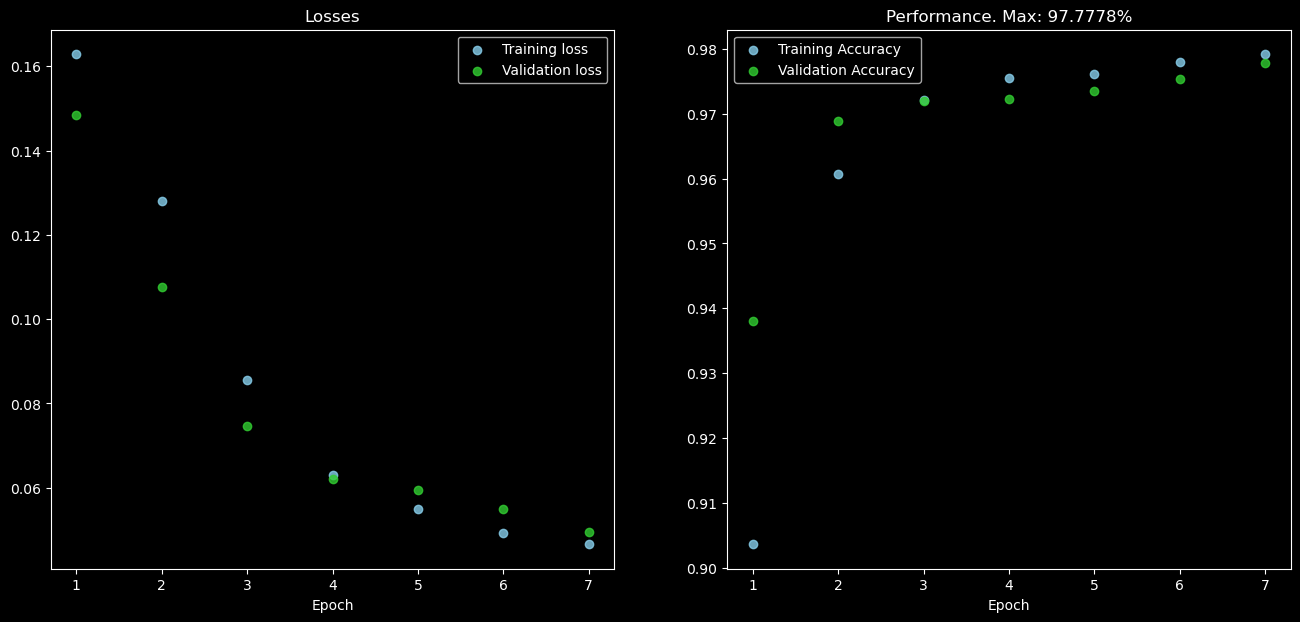

In [20]:
plot_performance(model)

  0%|          | 0/100 [00:00<?, ?it/s]

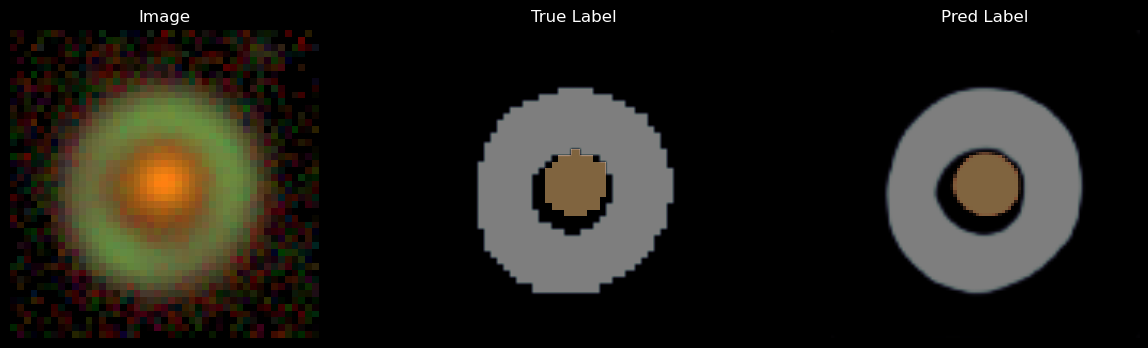

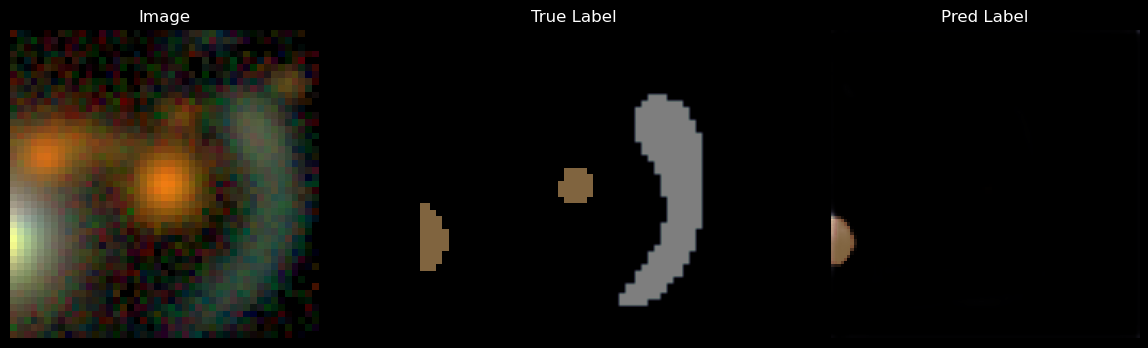

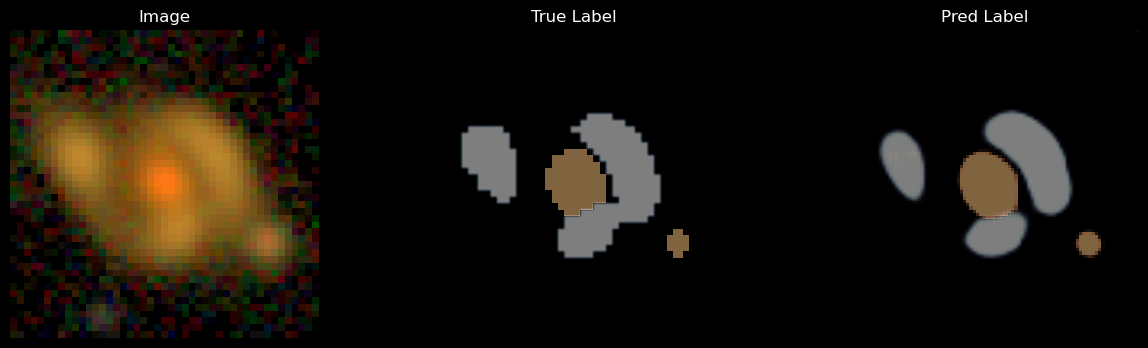

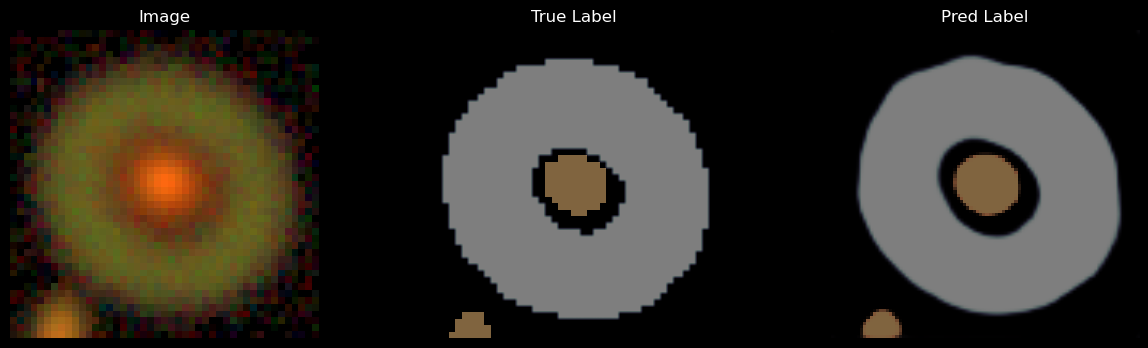

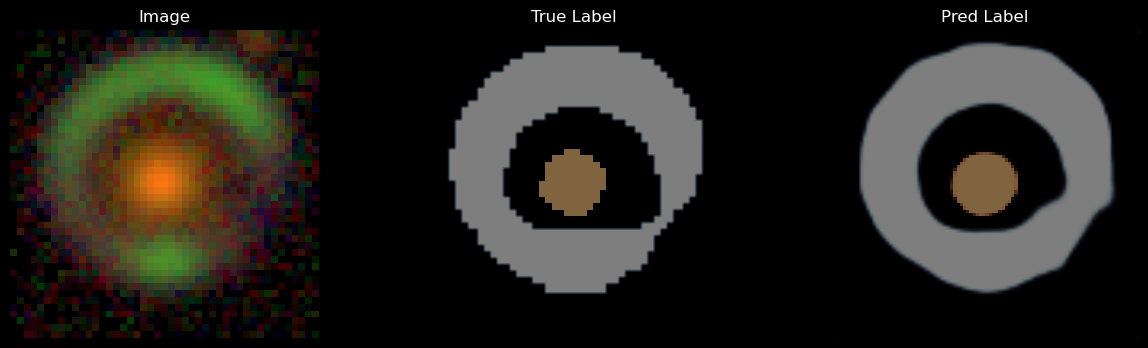

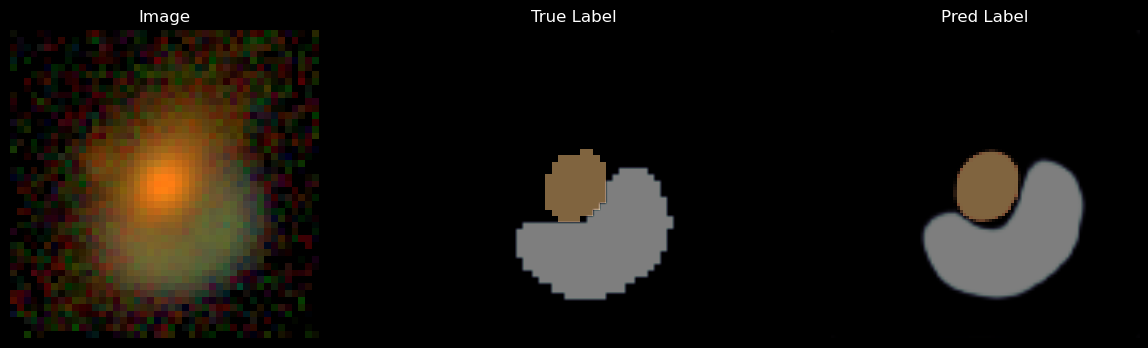

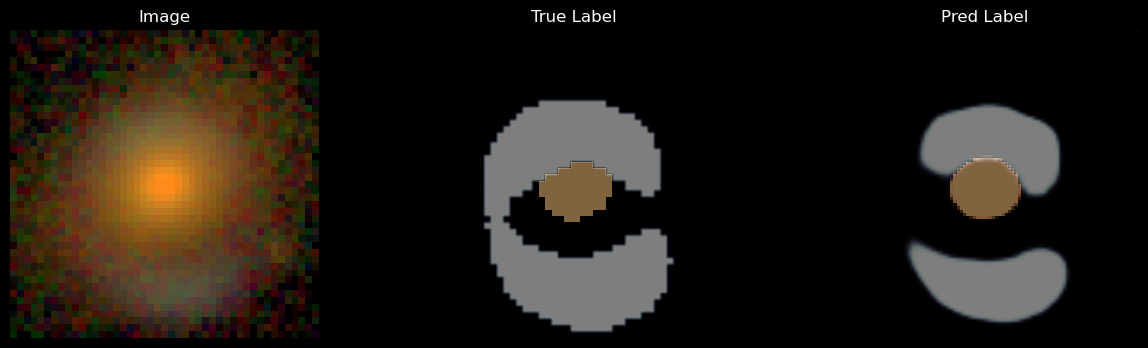

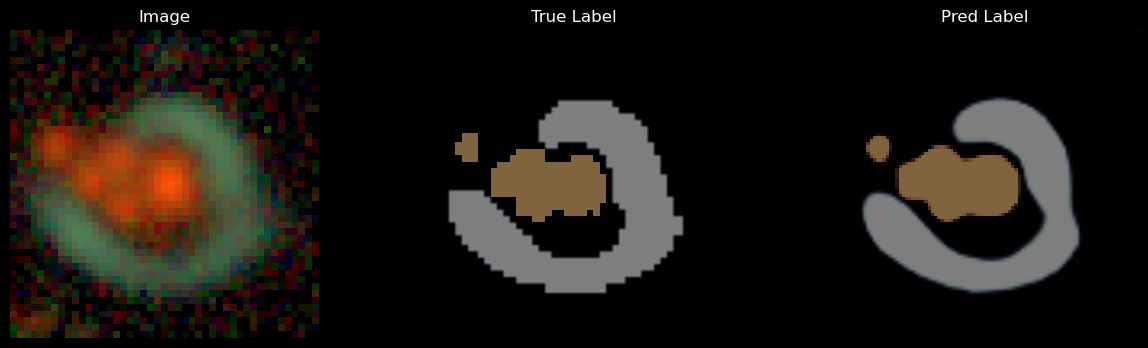

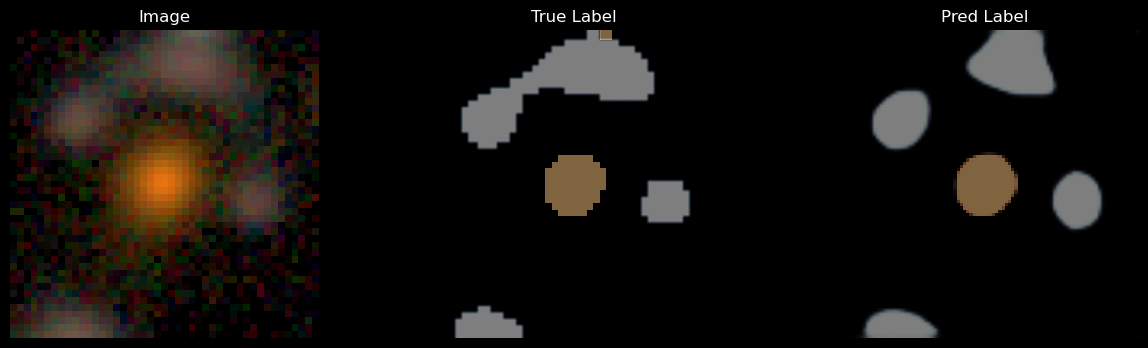

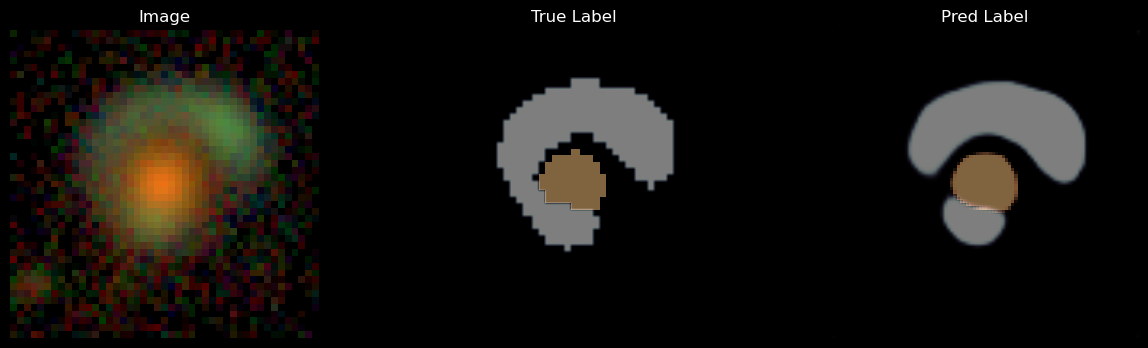

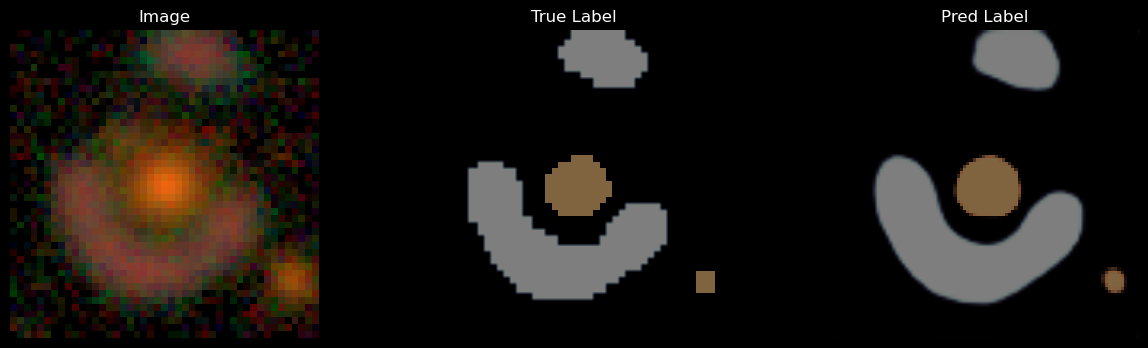

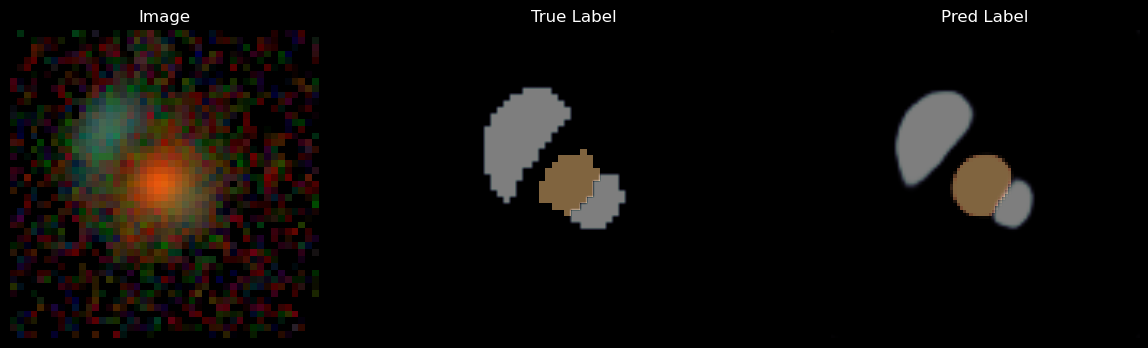

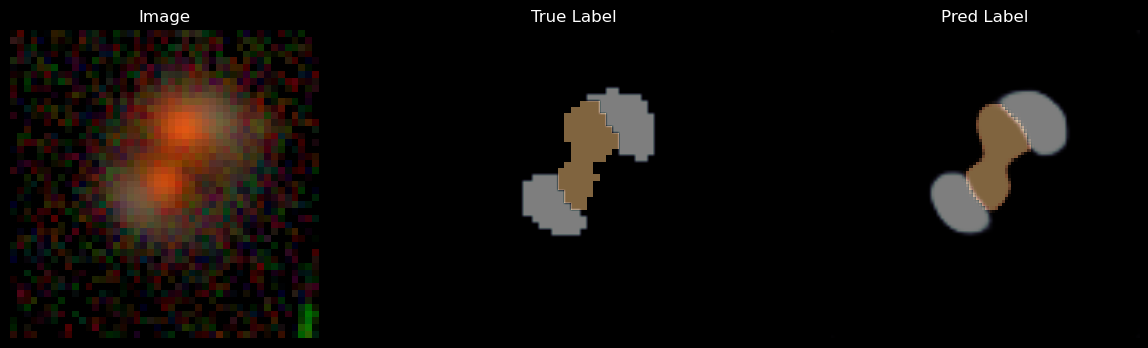

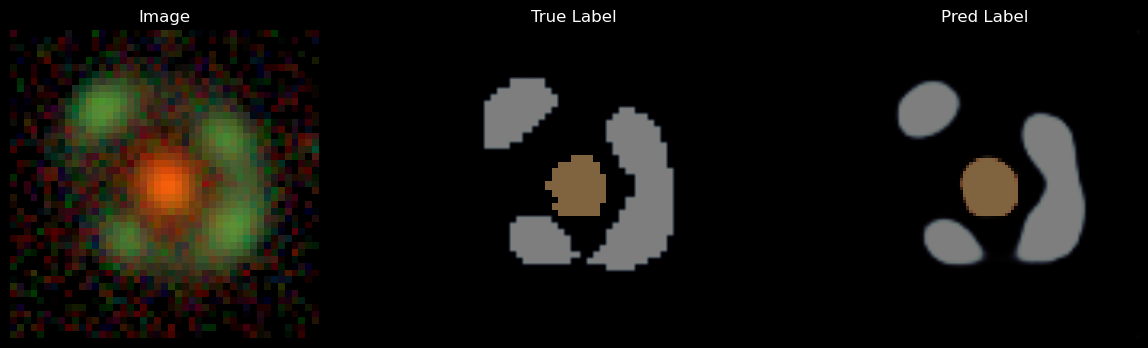

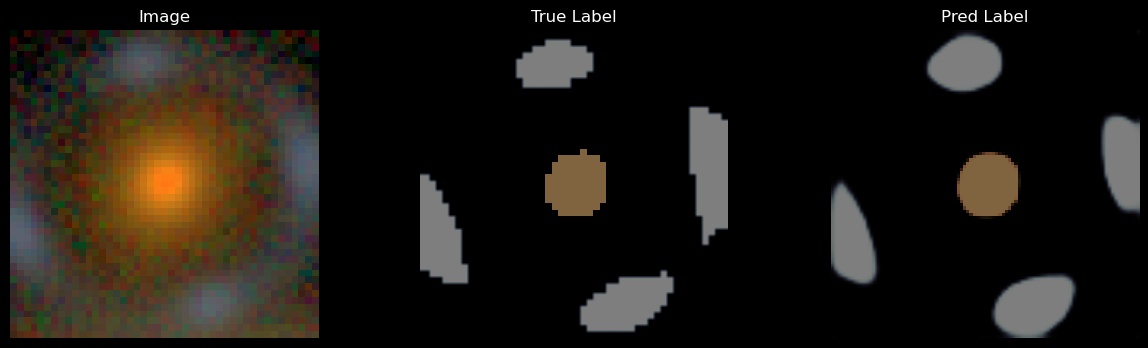

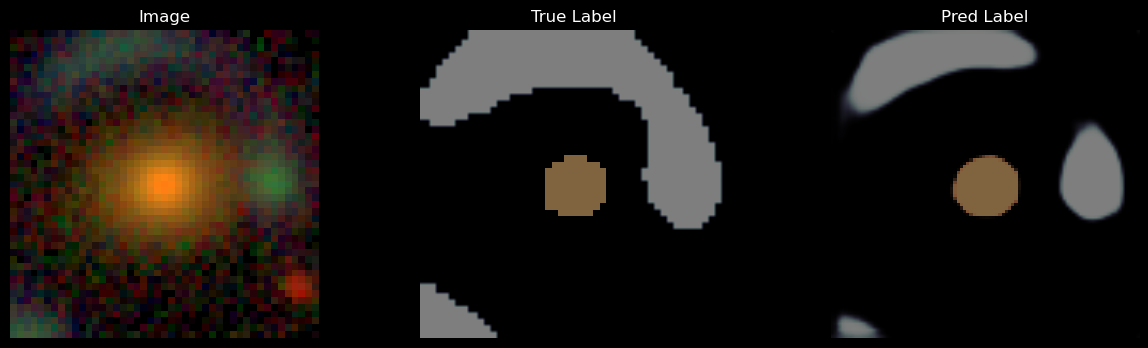

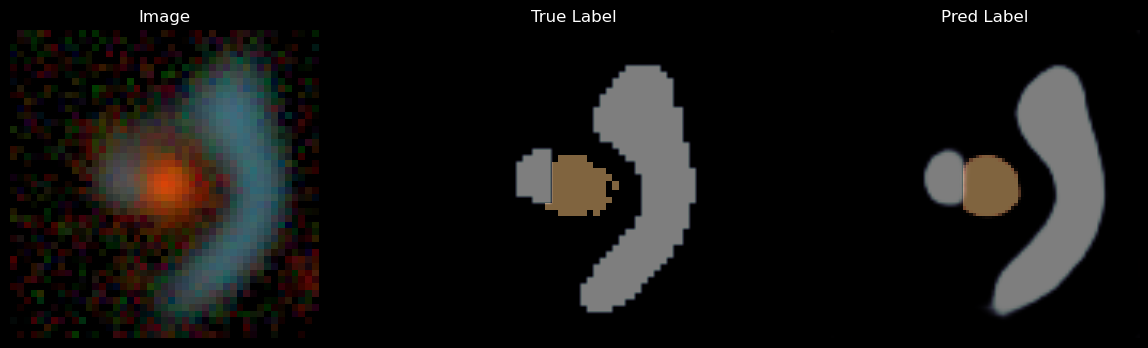

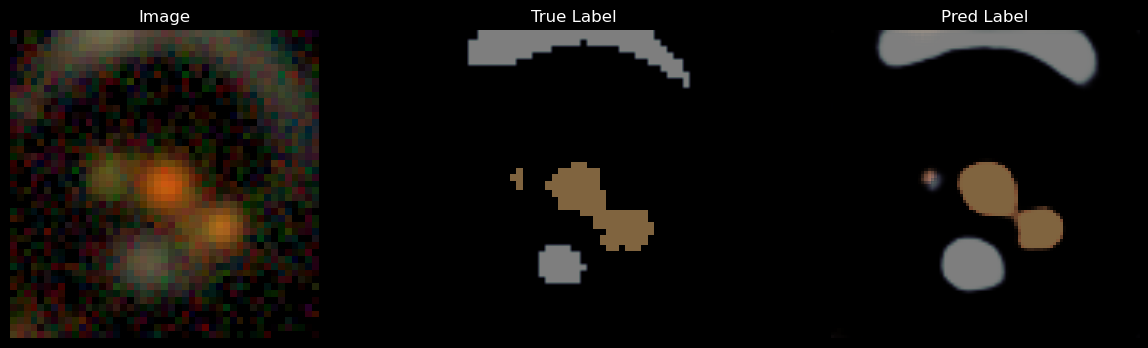

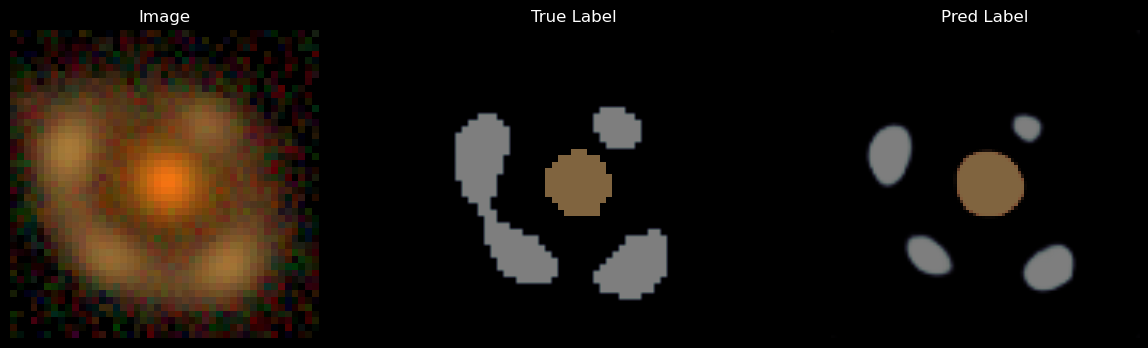

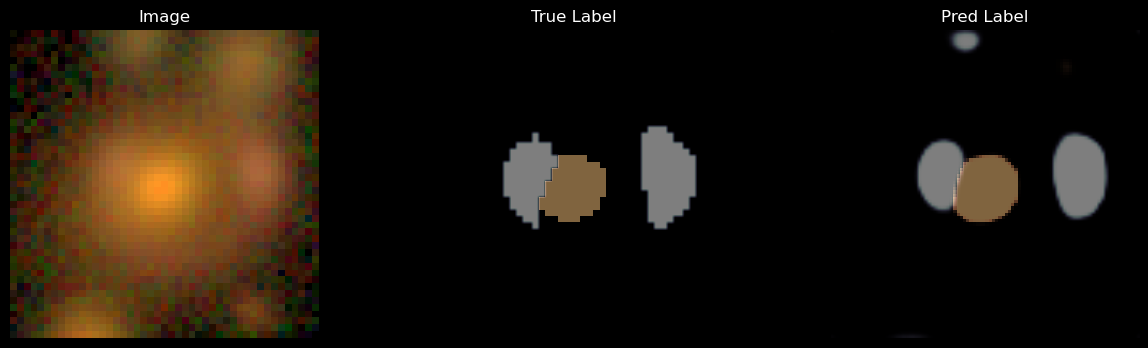

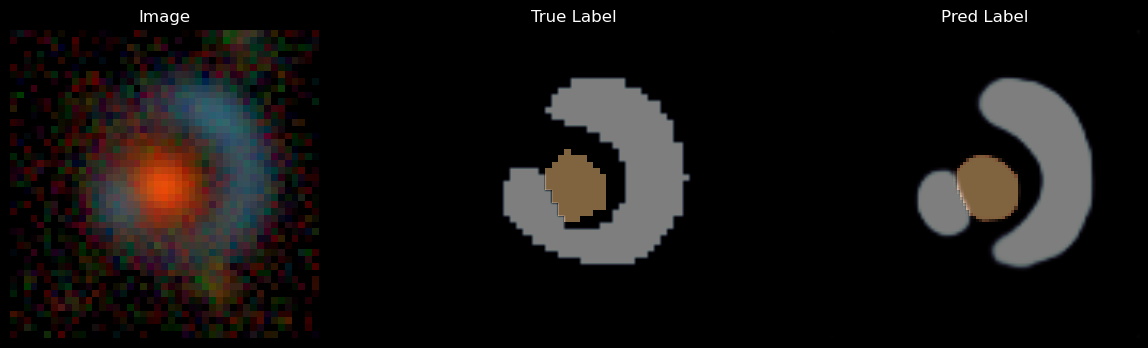

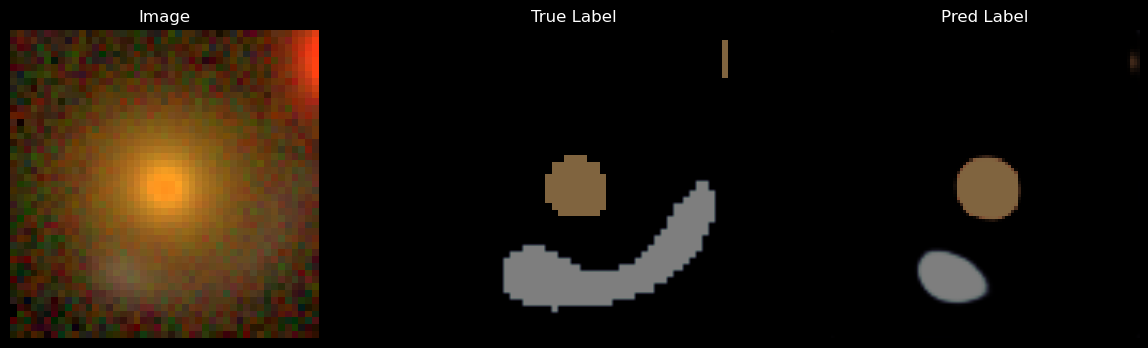

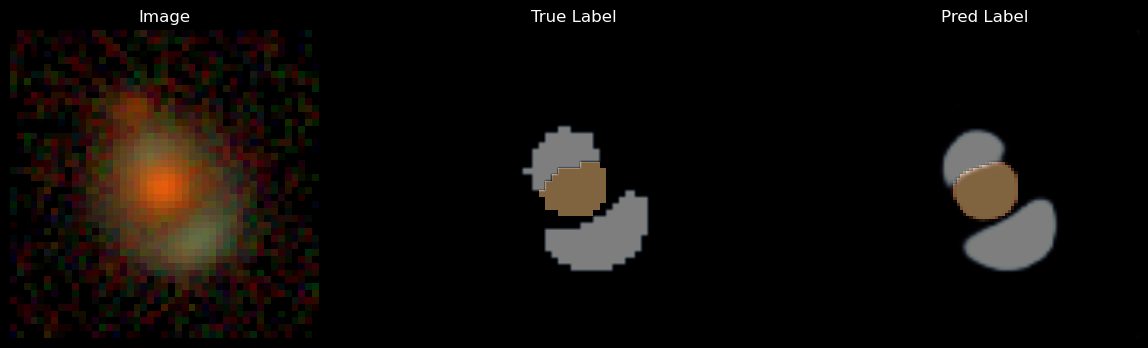

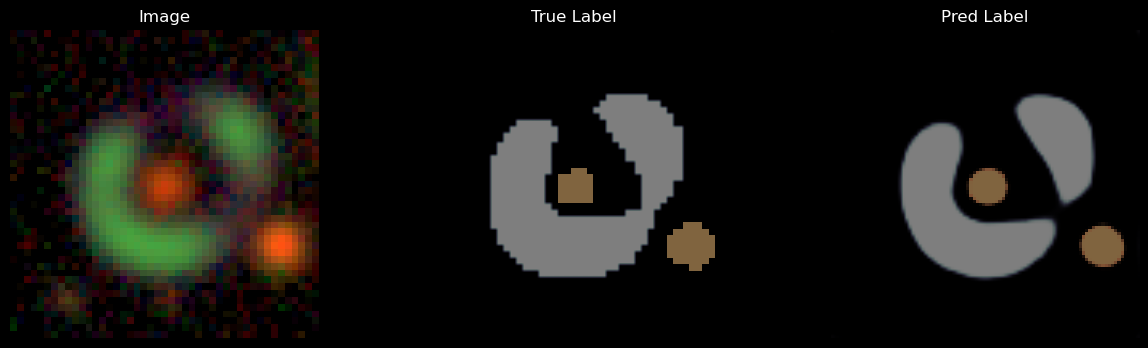

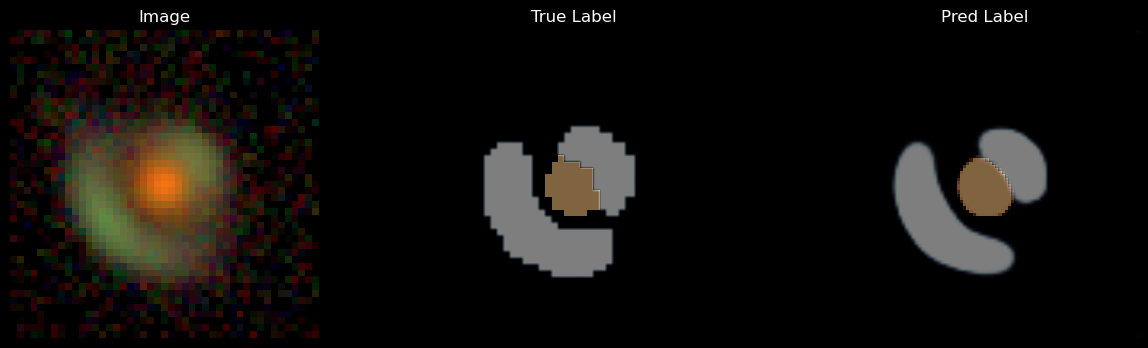

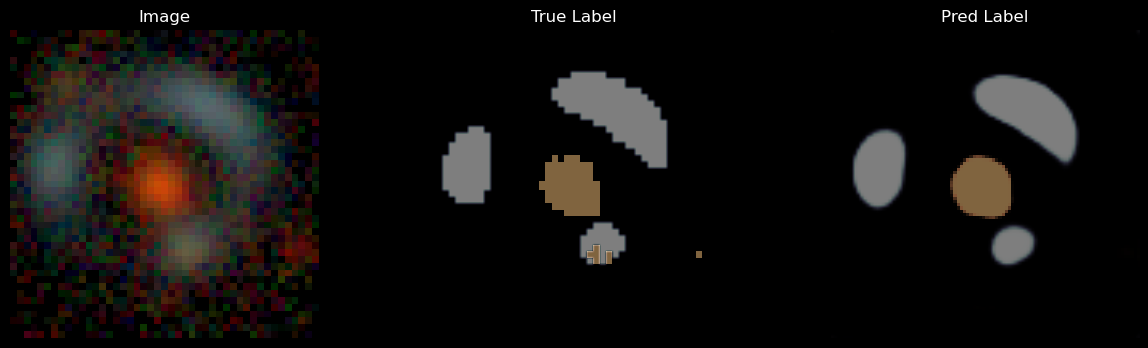

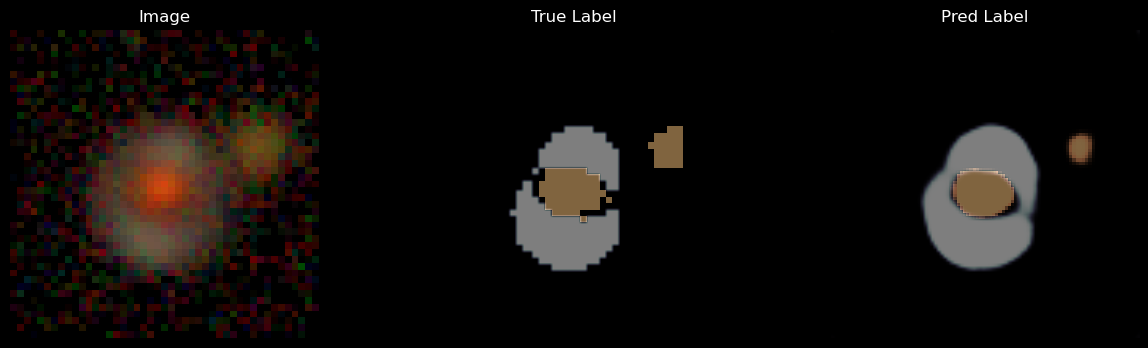

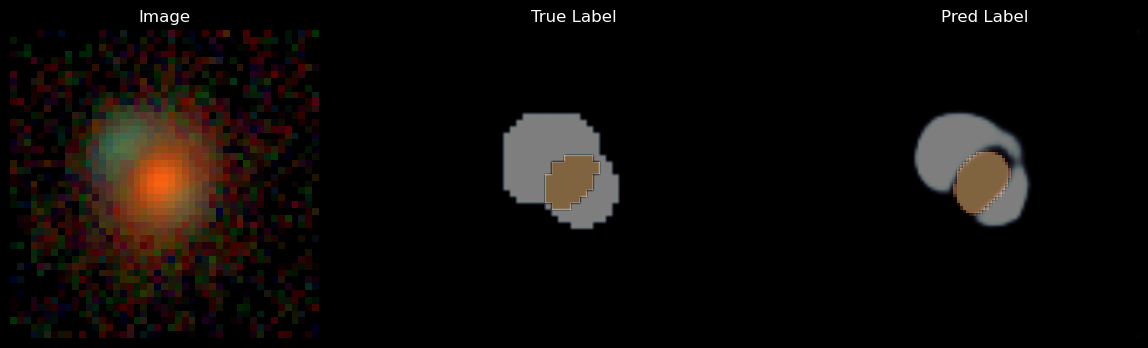

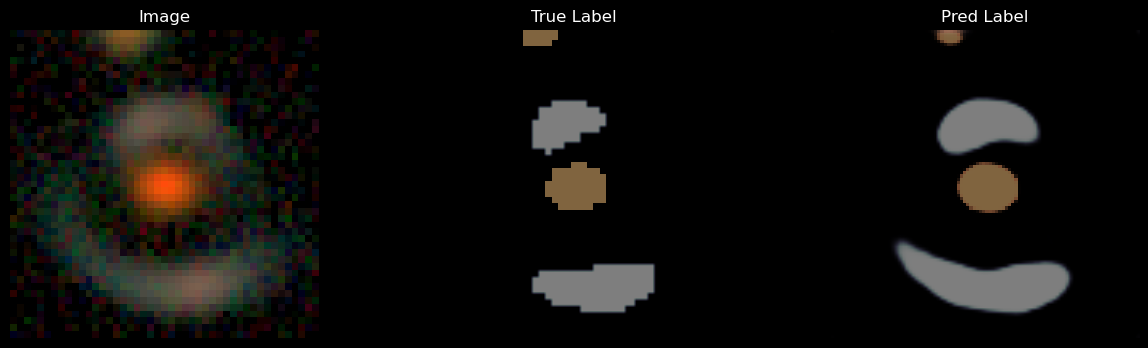

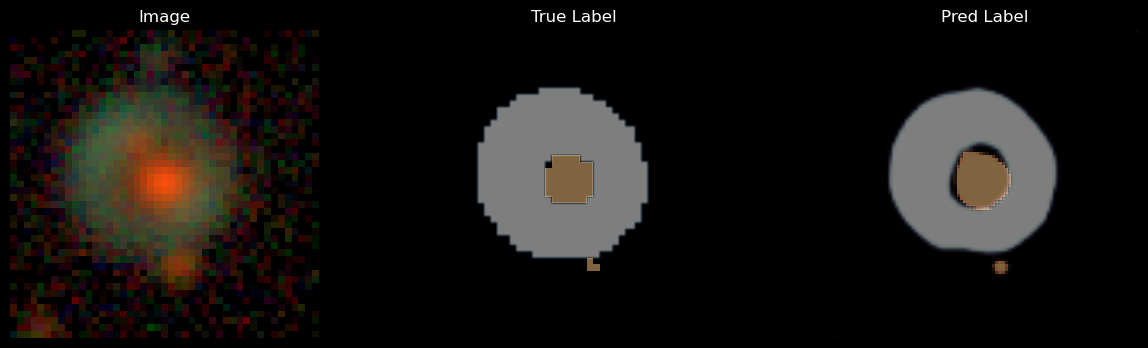

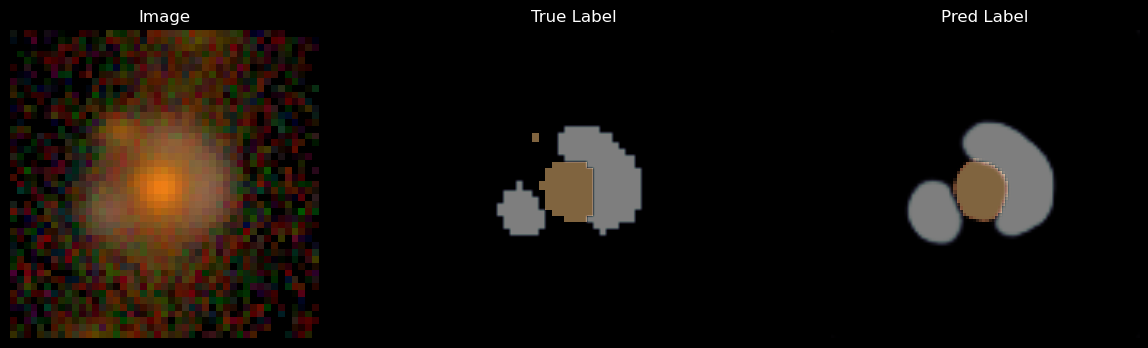

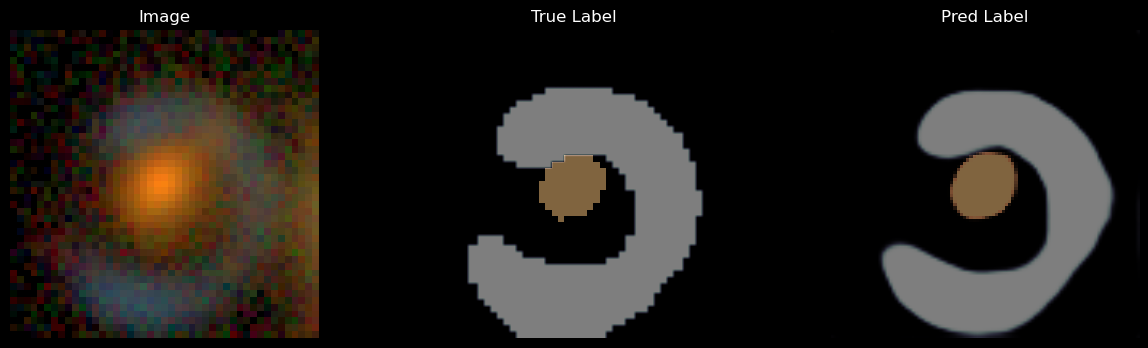

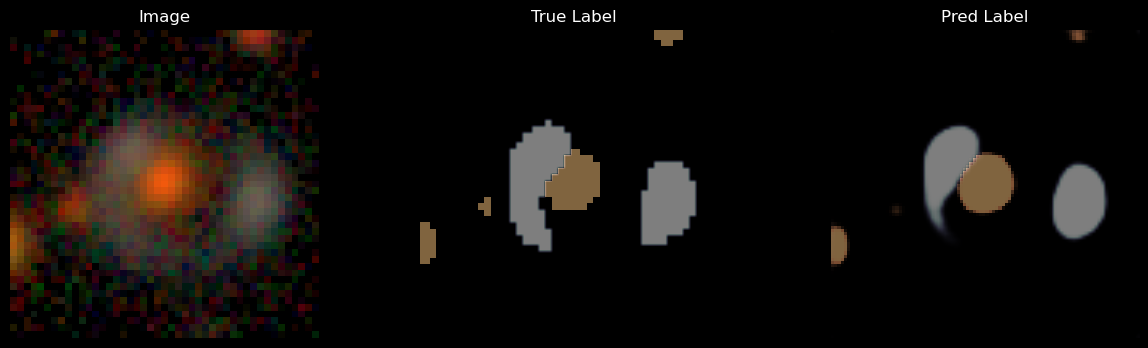

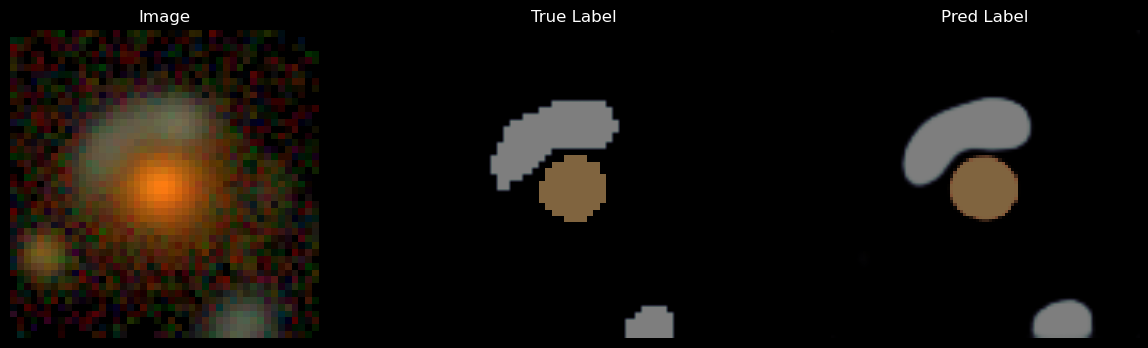

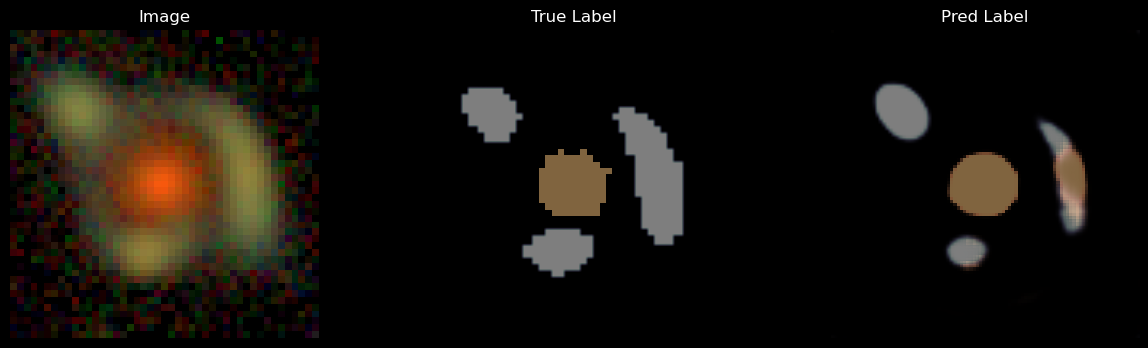

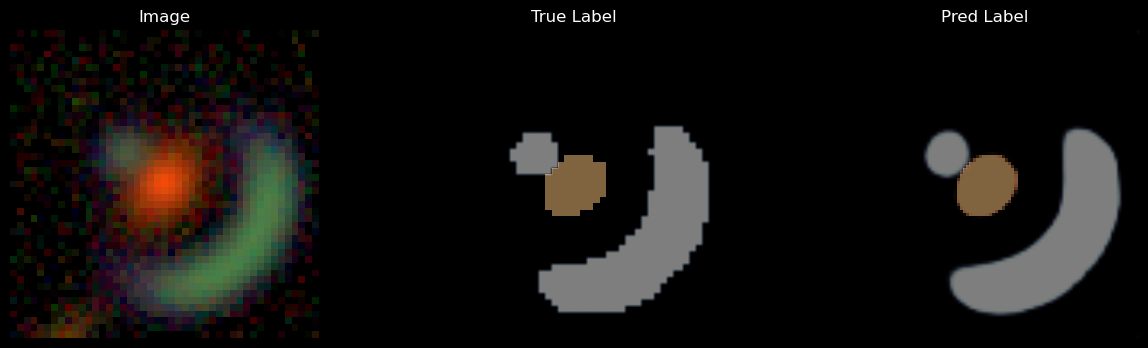

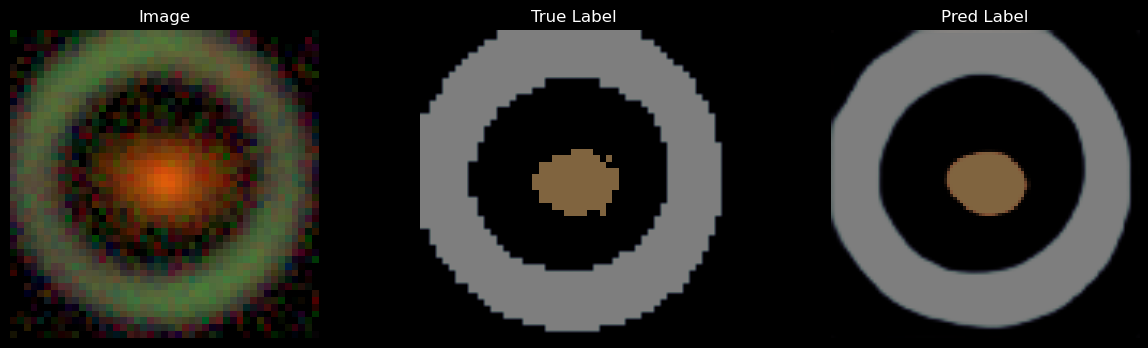

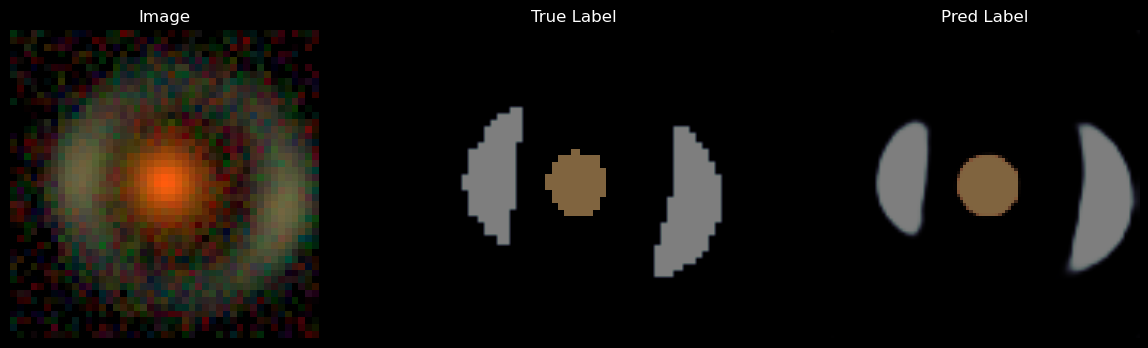

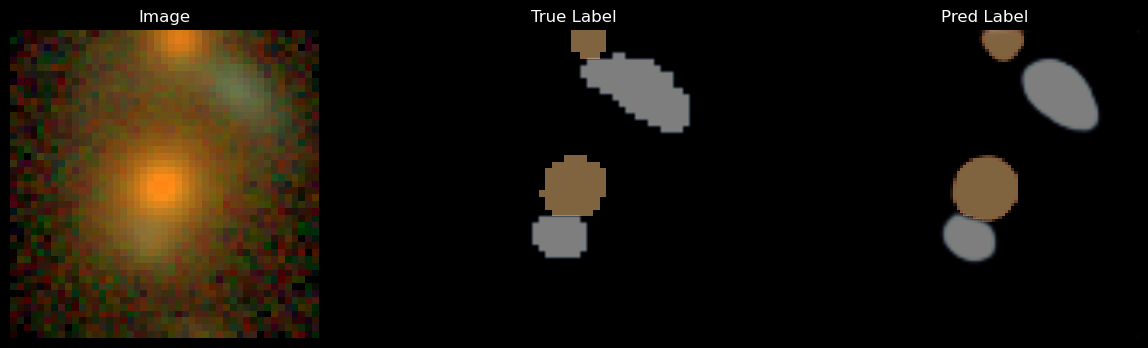

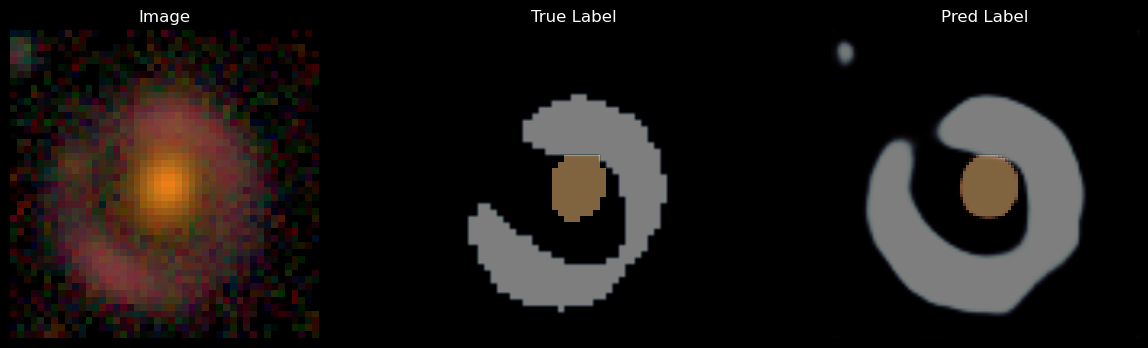

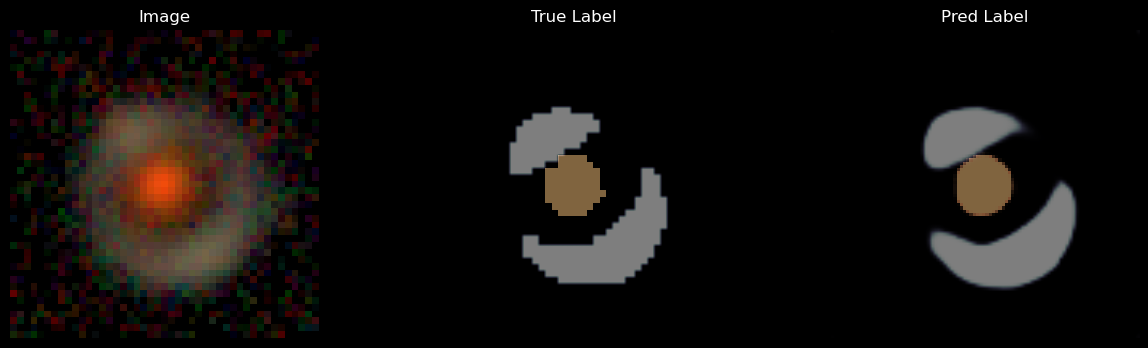

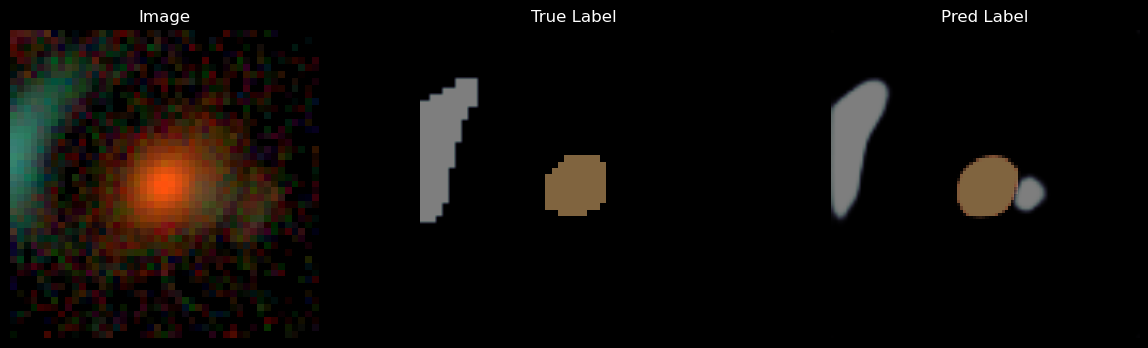

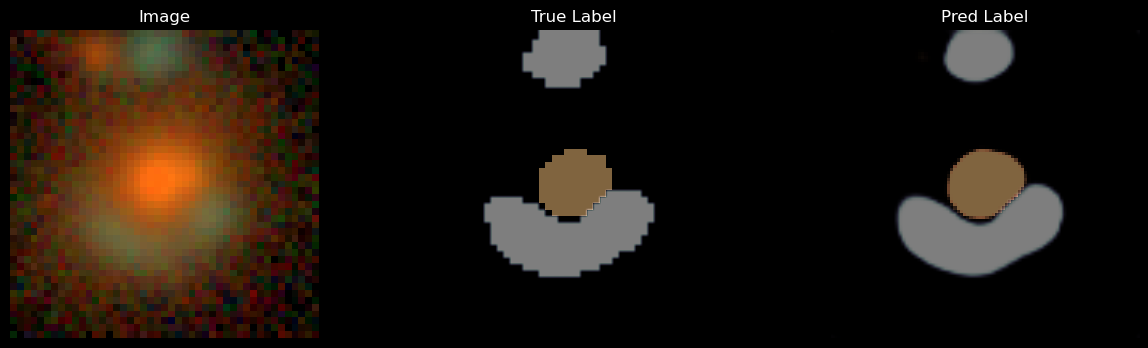

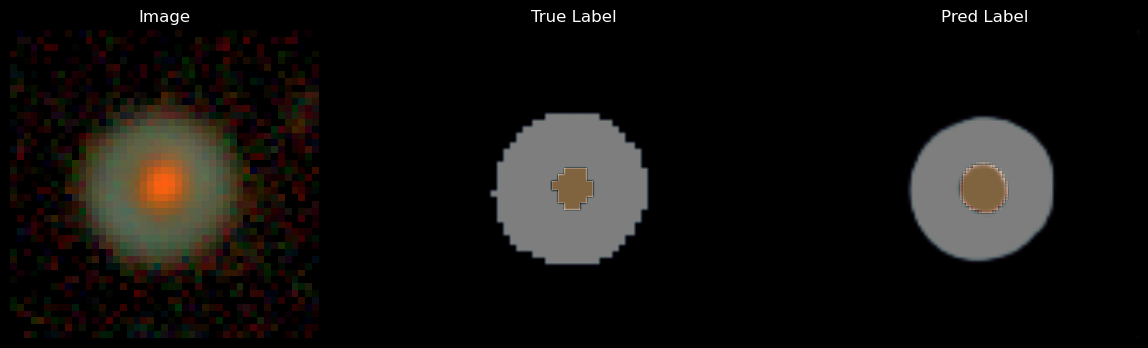

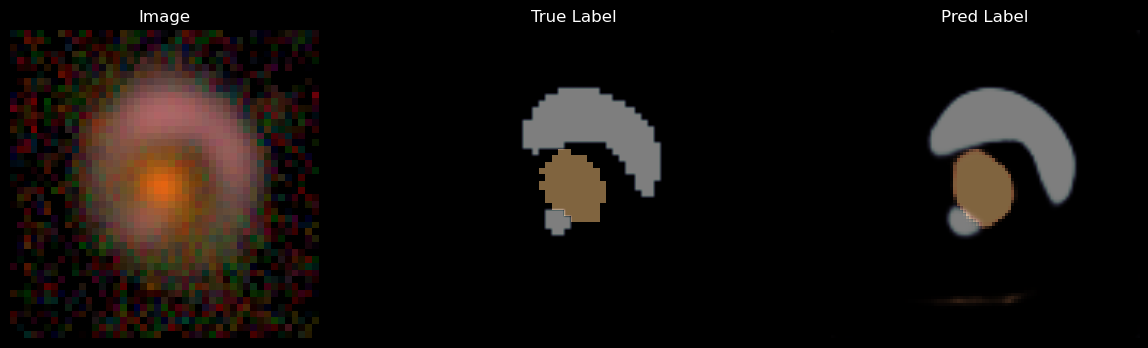

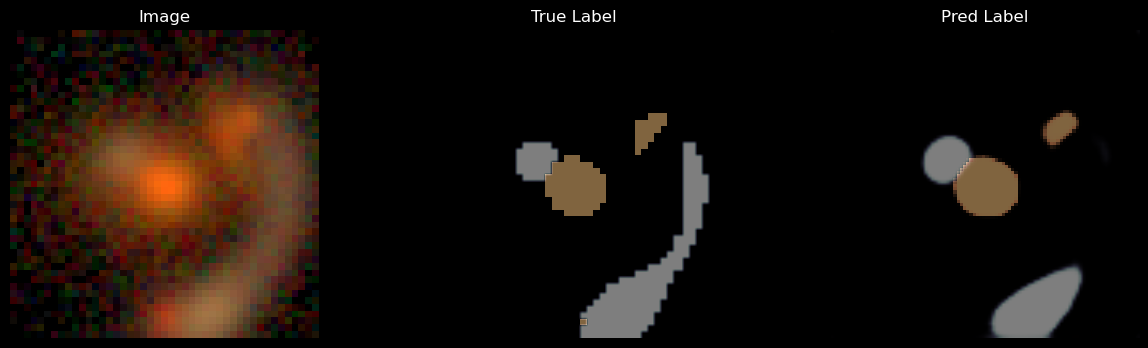

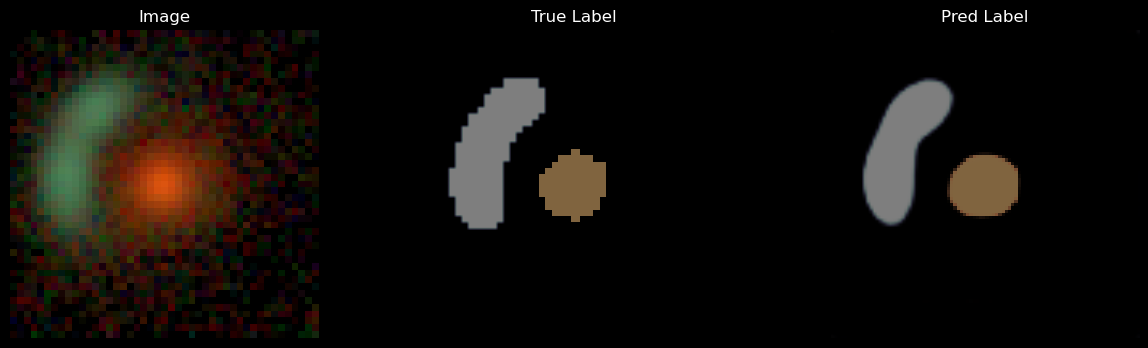

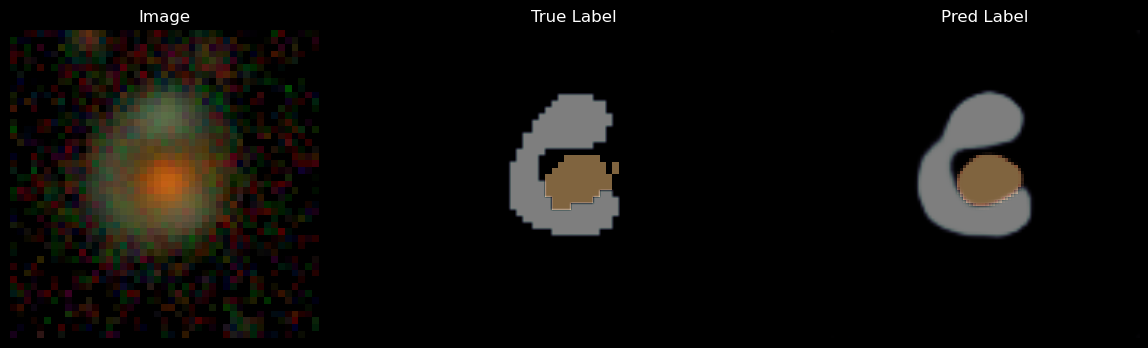

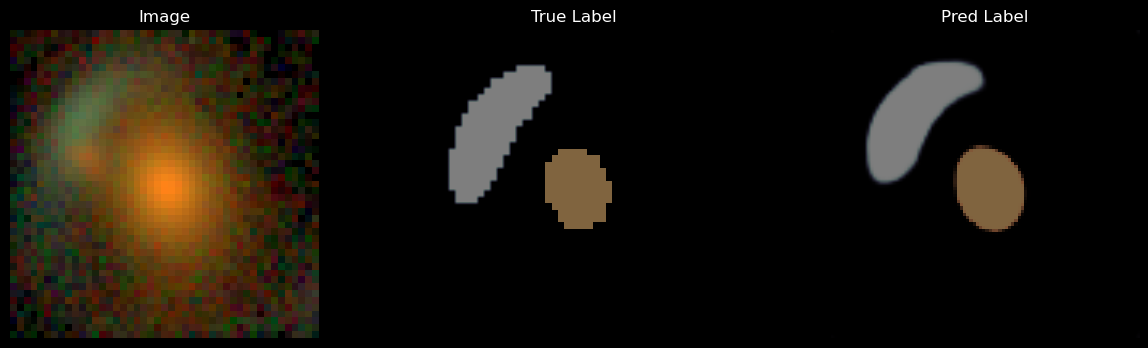

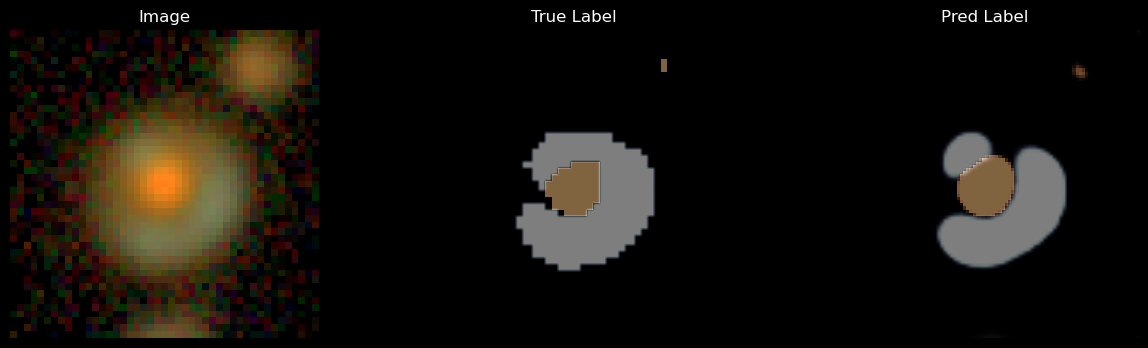

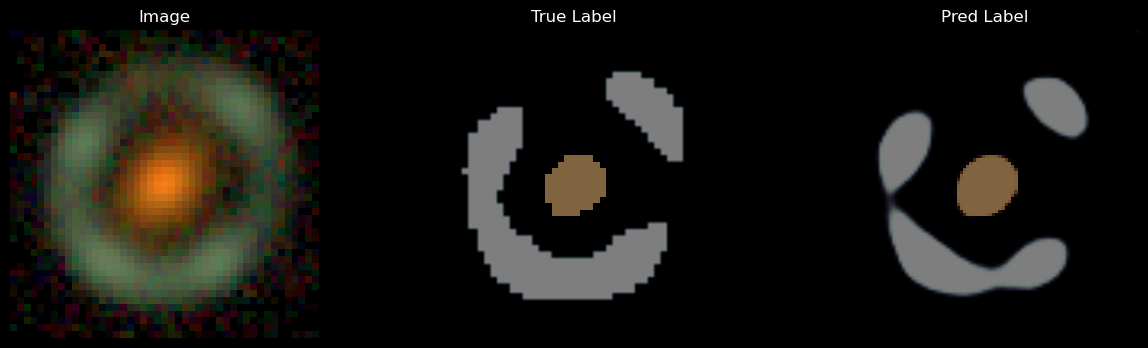

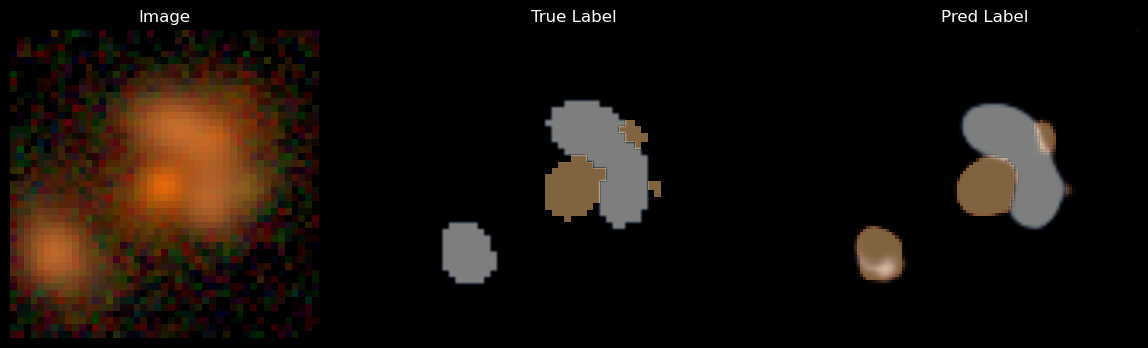

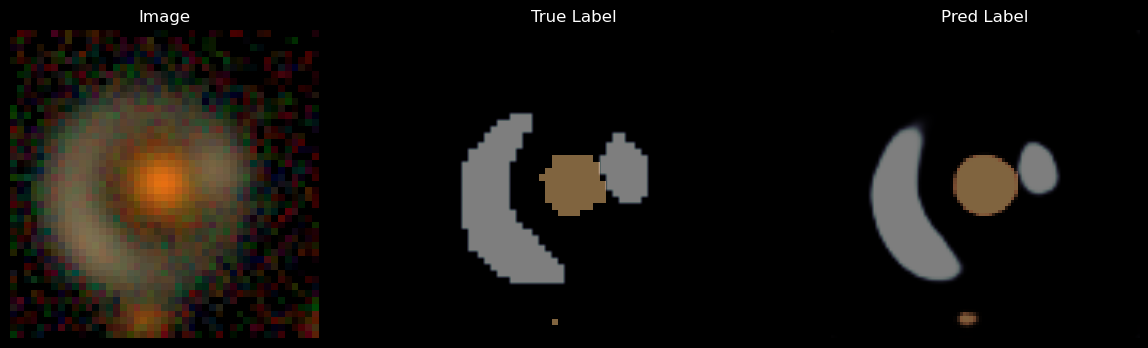

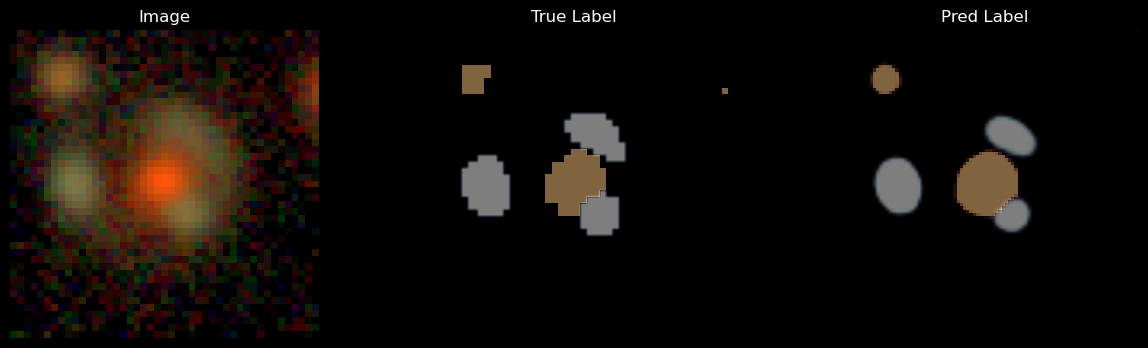

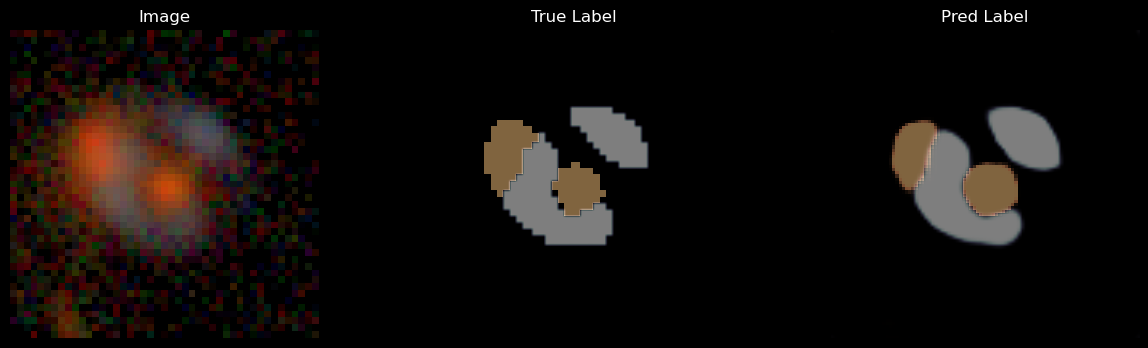

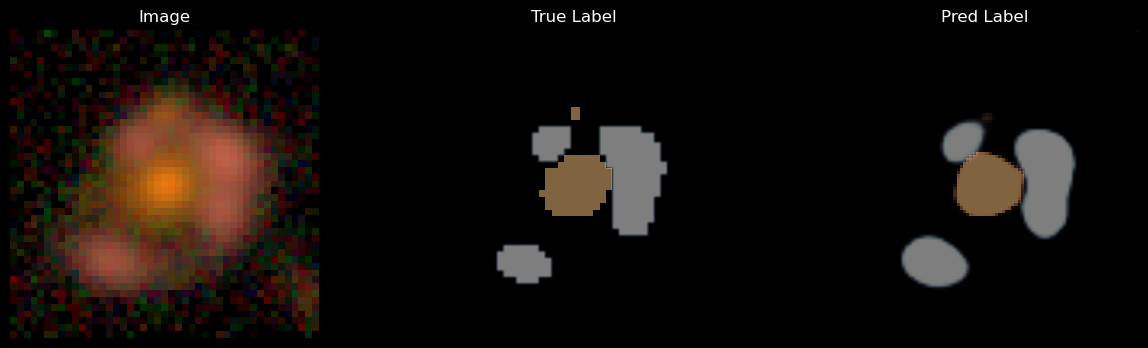

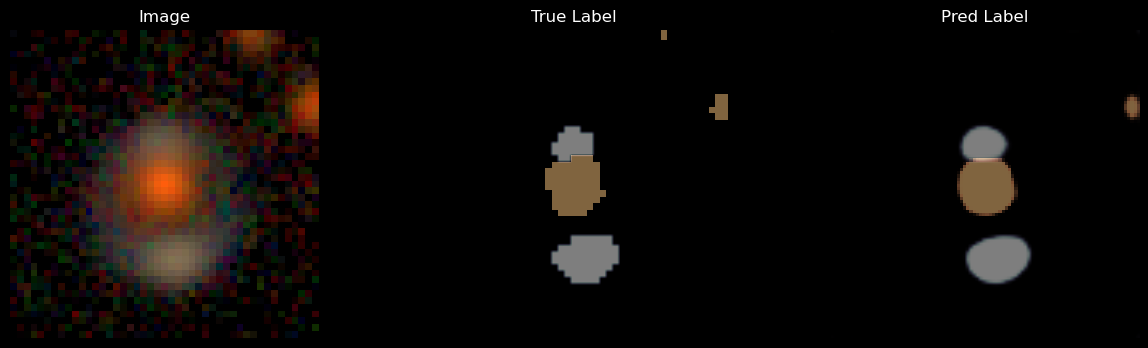

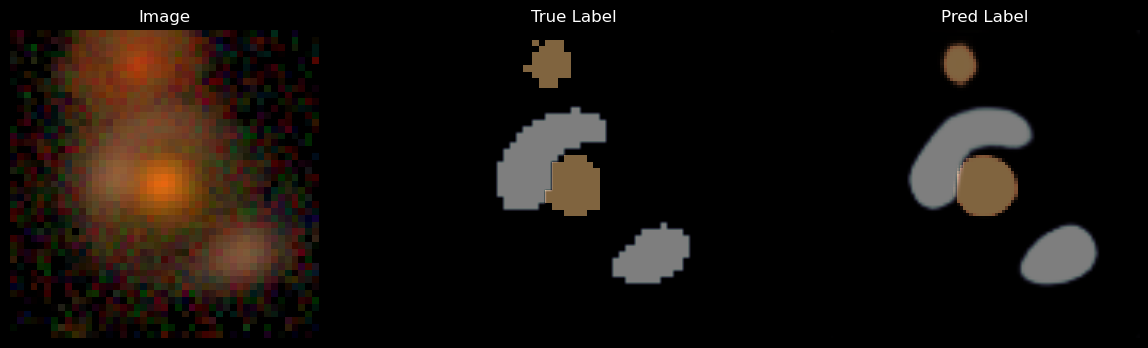

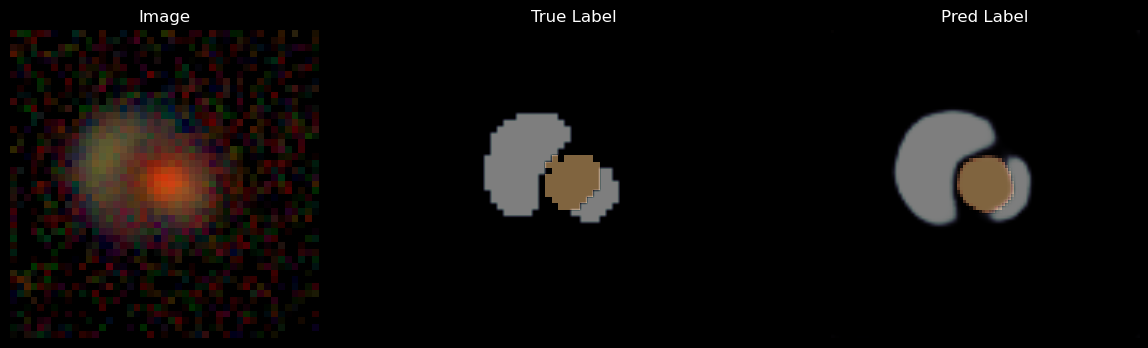

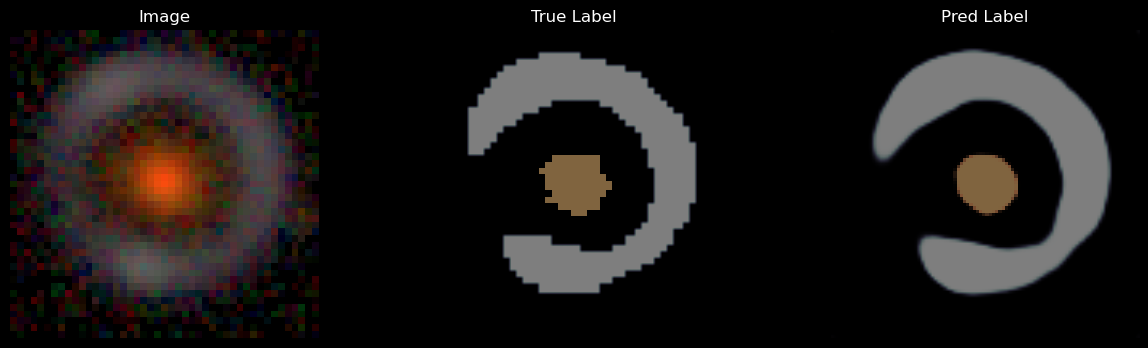

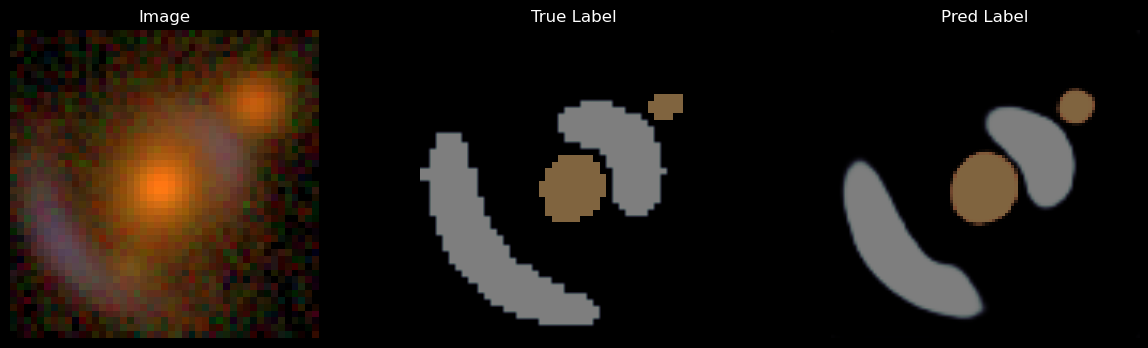

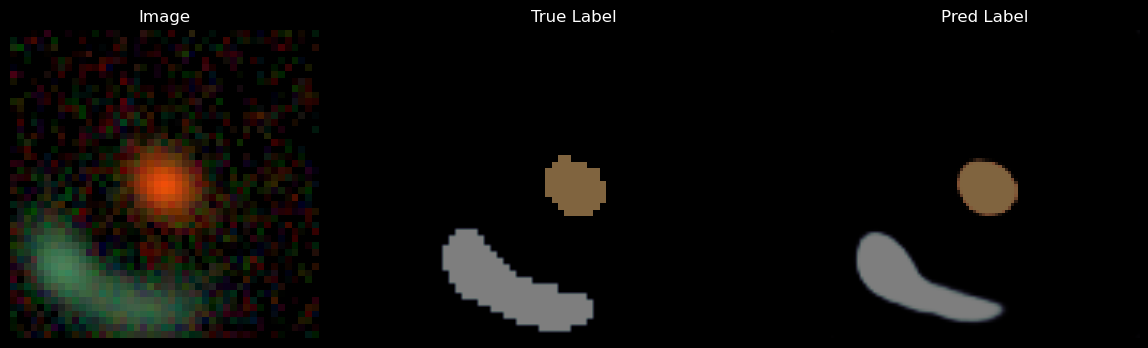

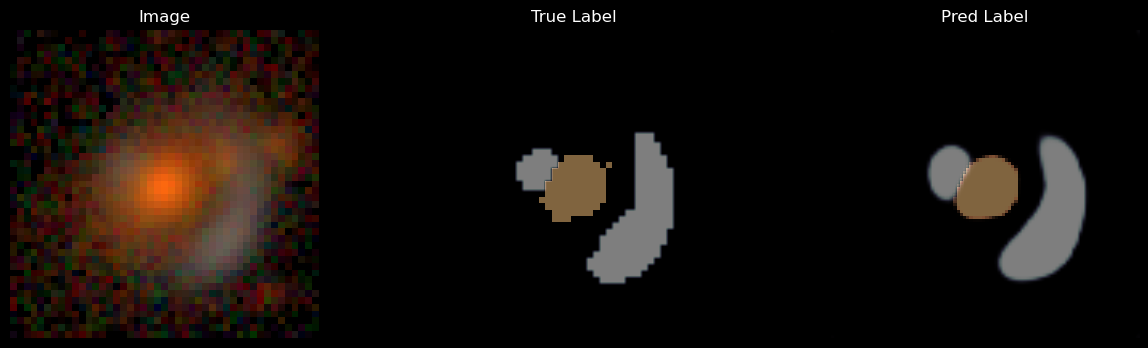

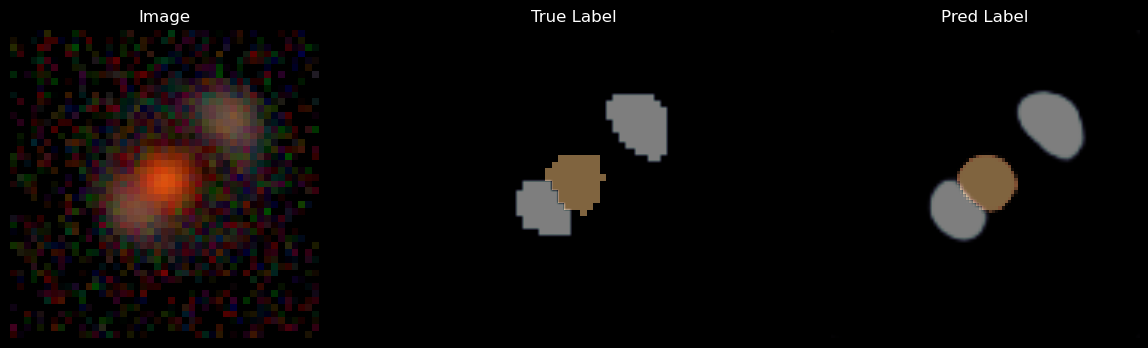

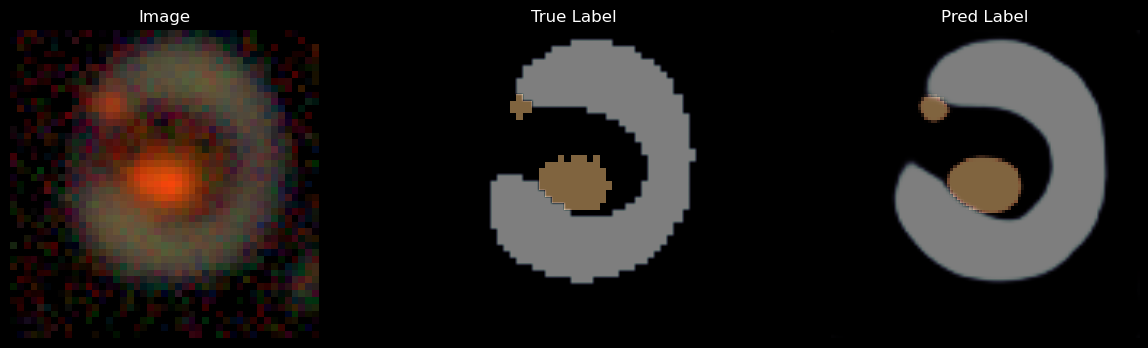

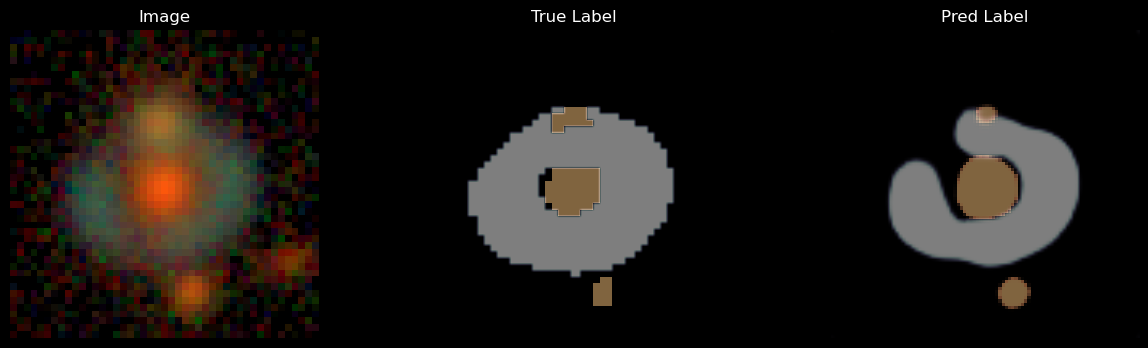

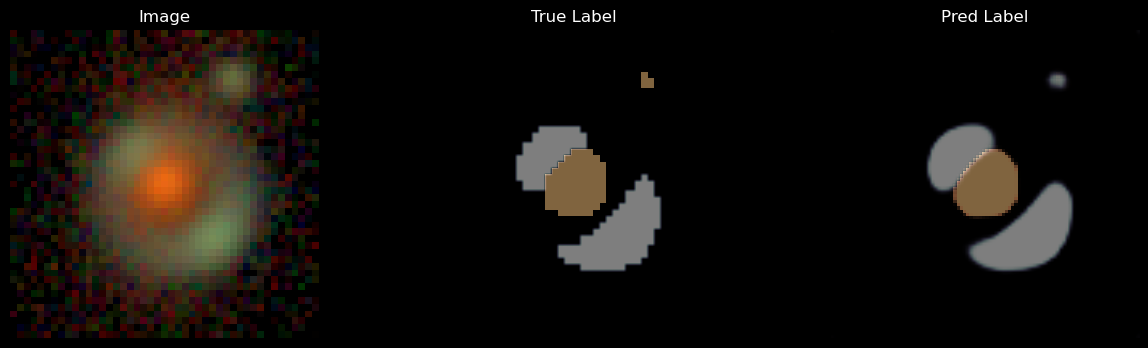

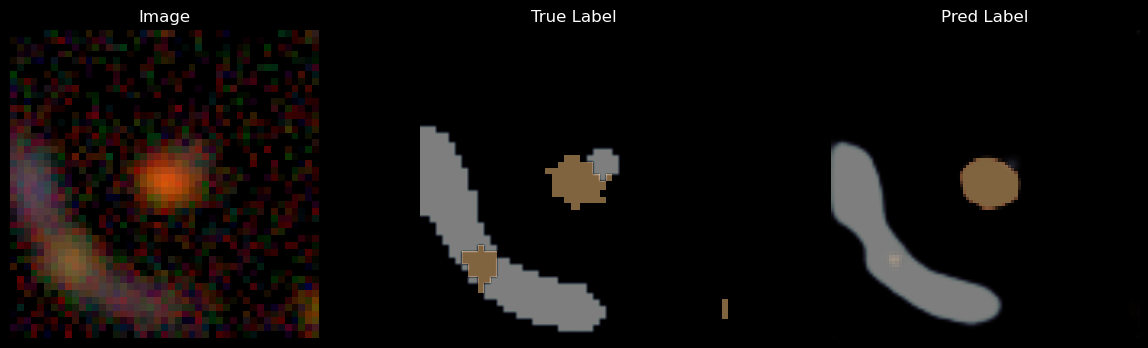

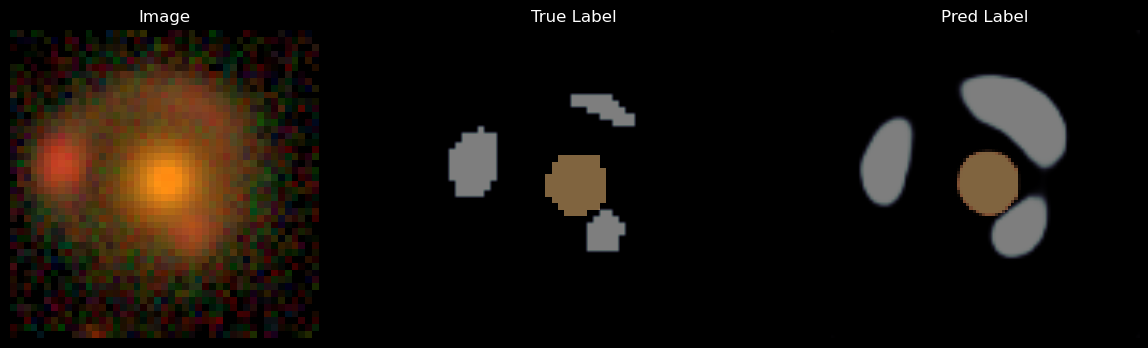

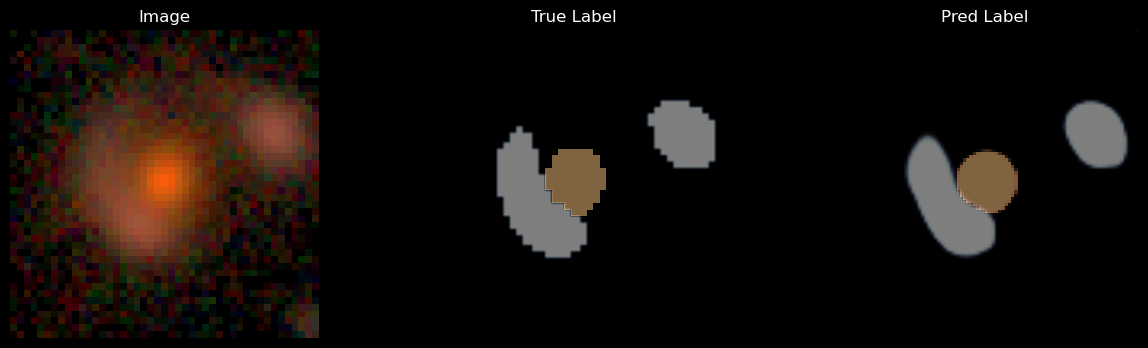

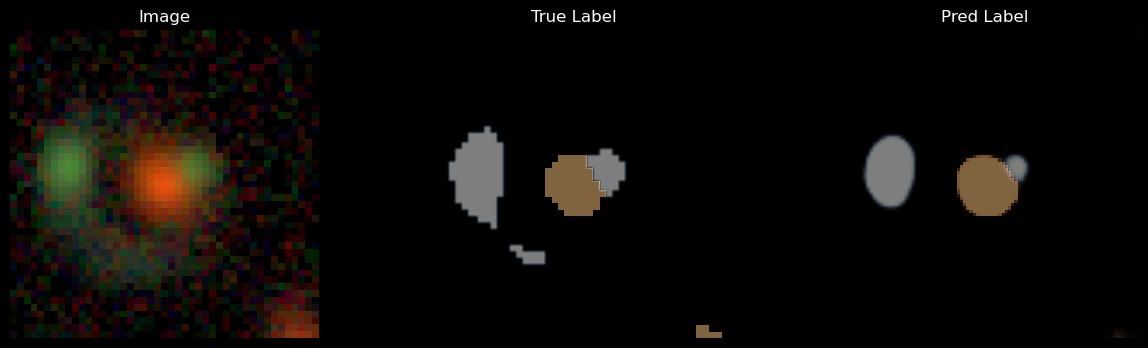

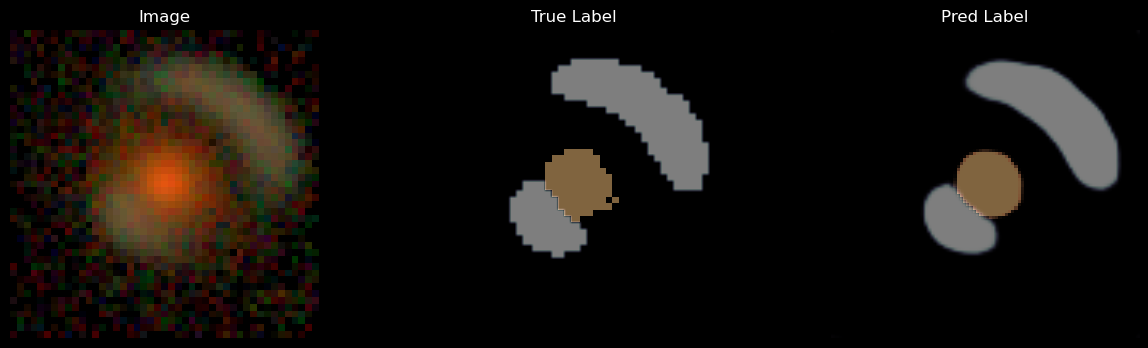

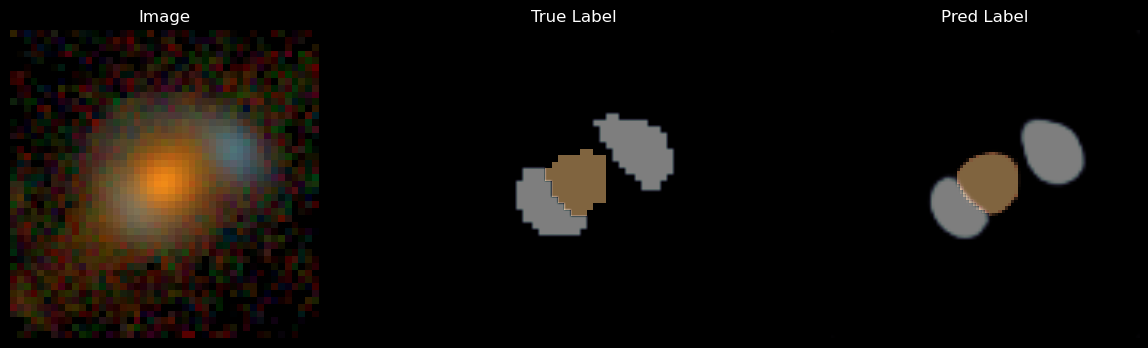

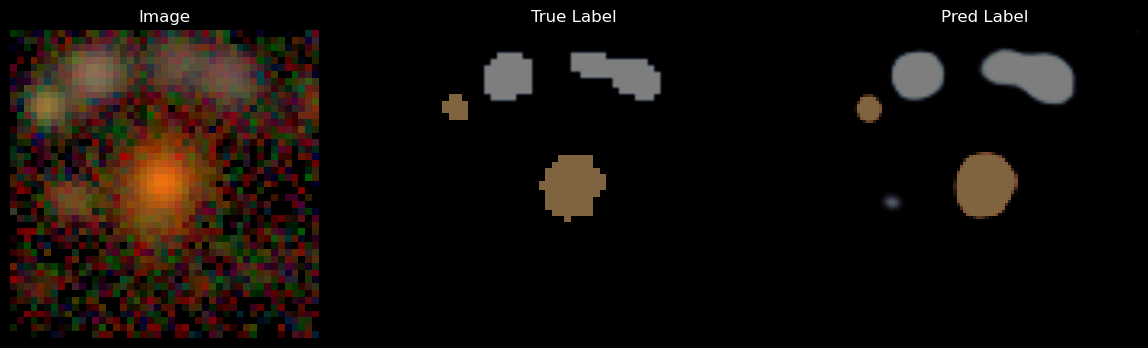

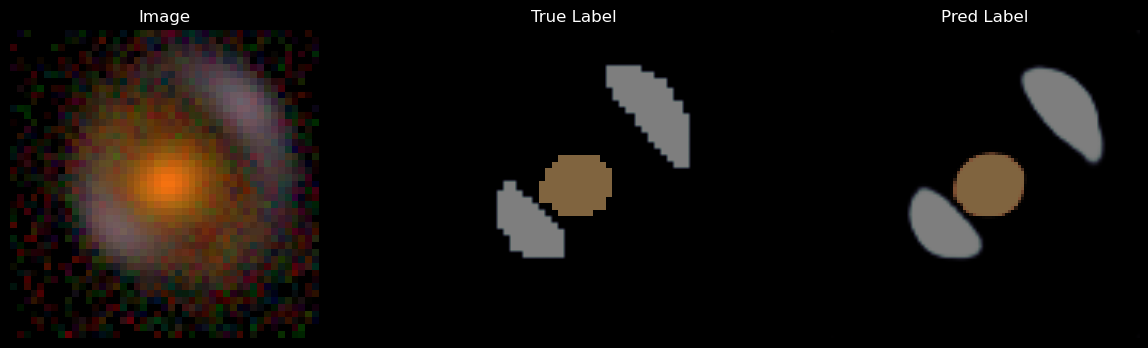

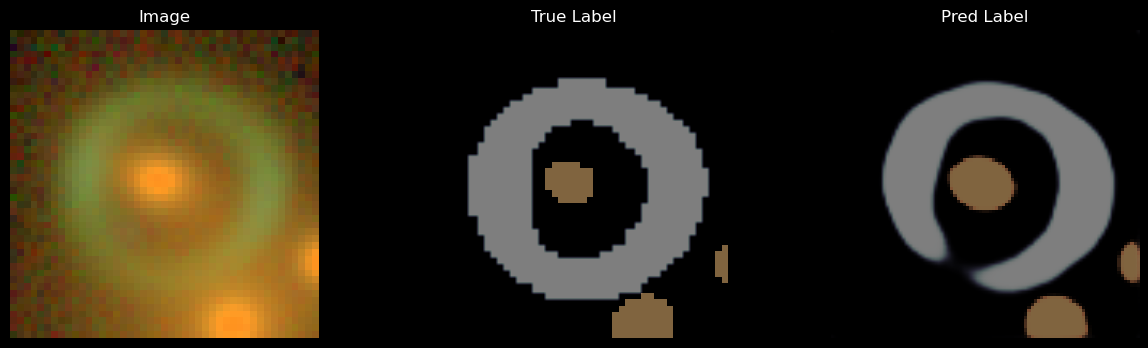

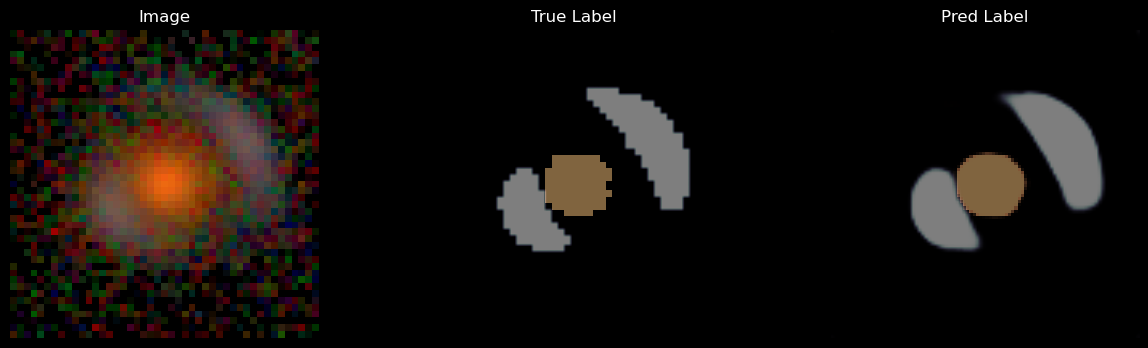

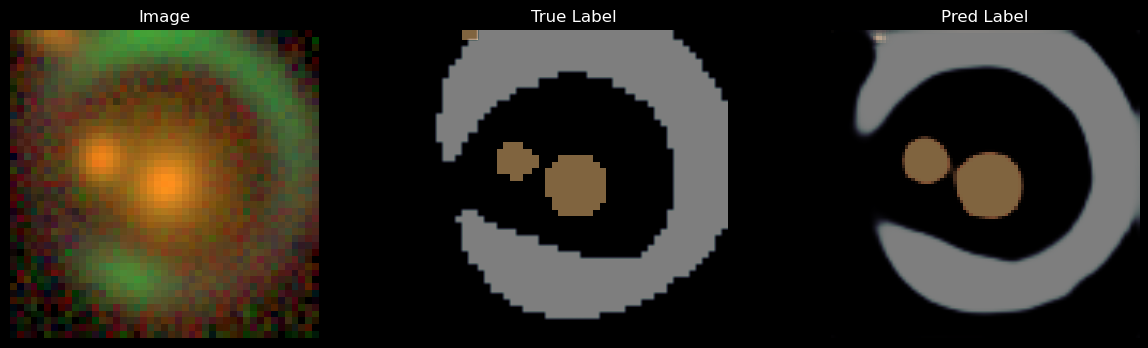

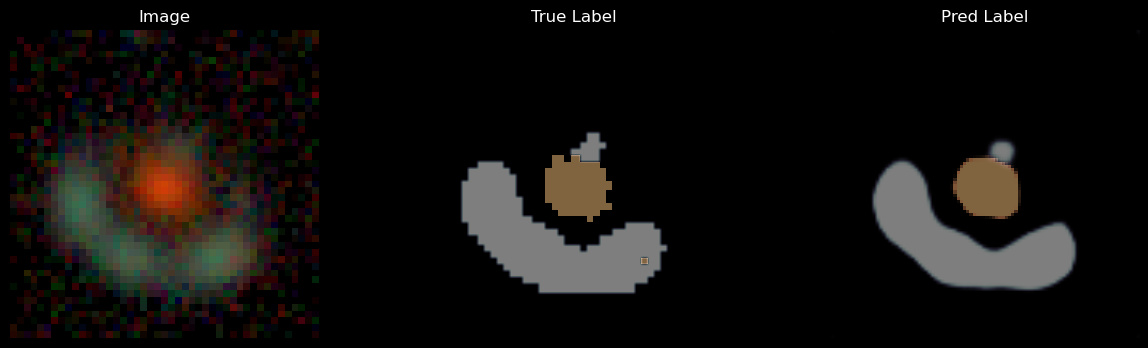

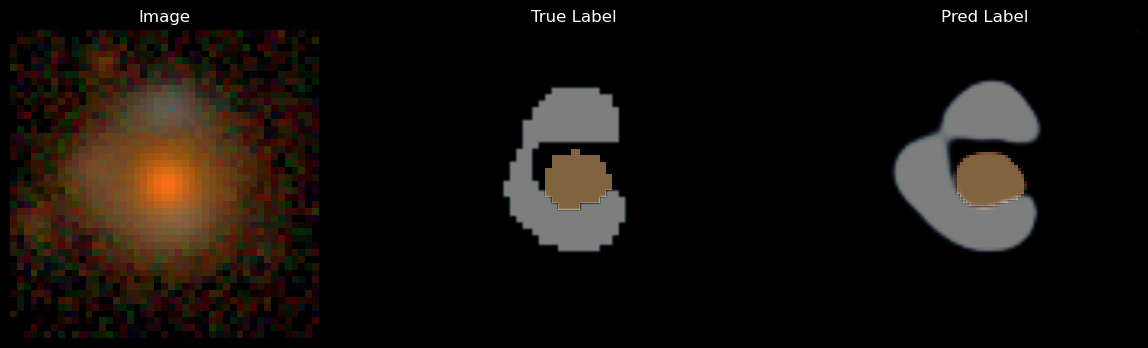

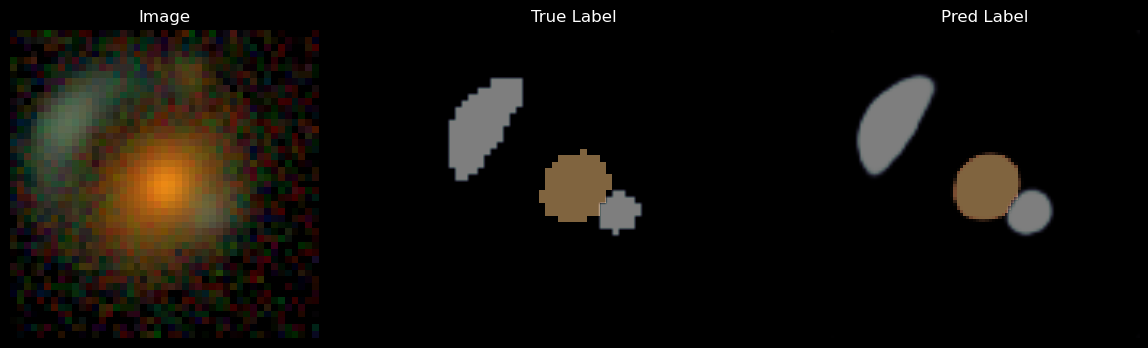

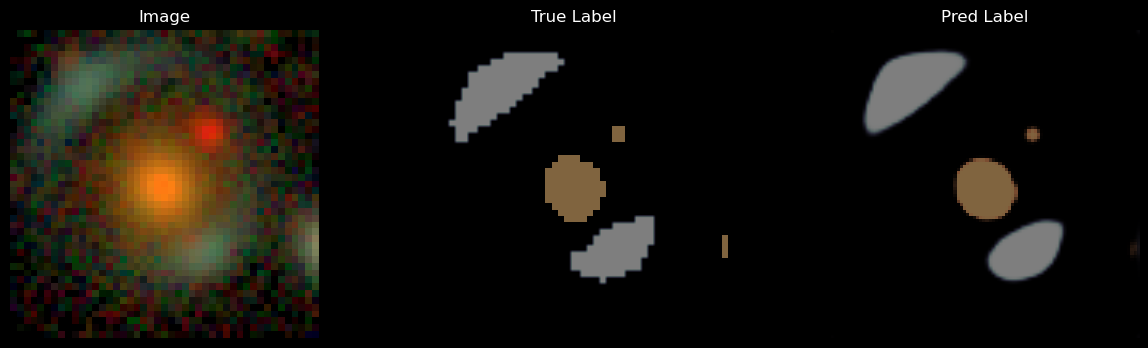

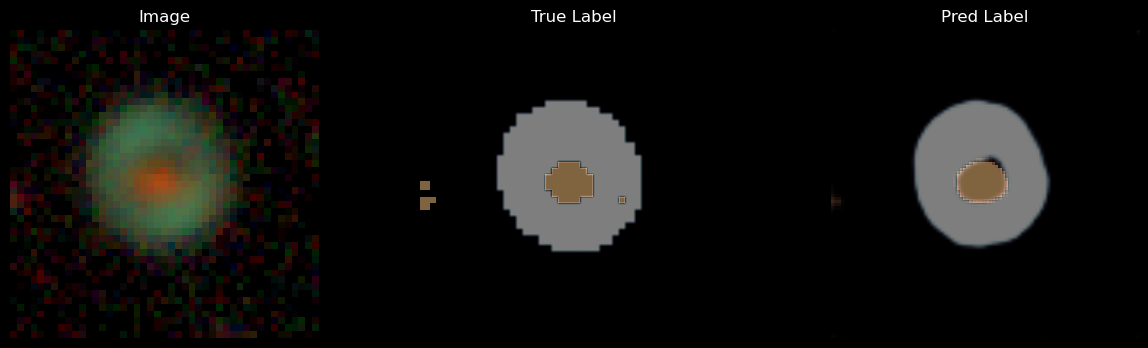

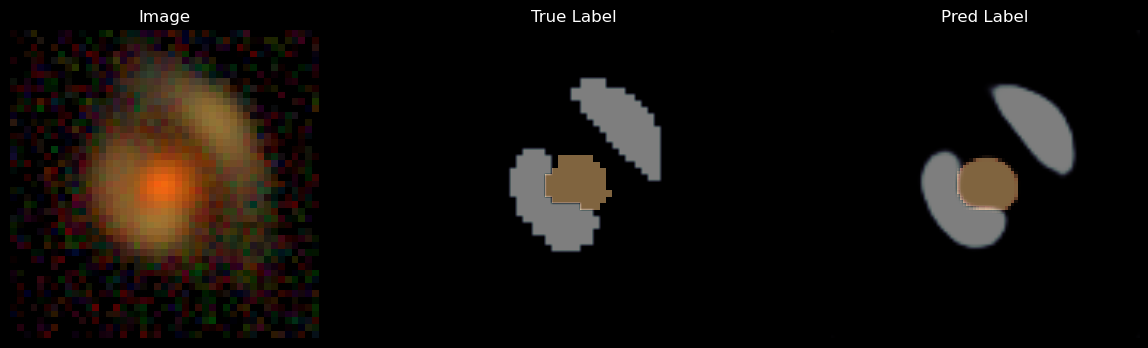

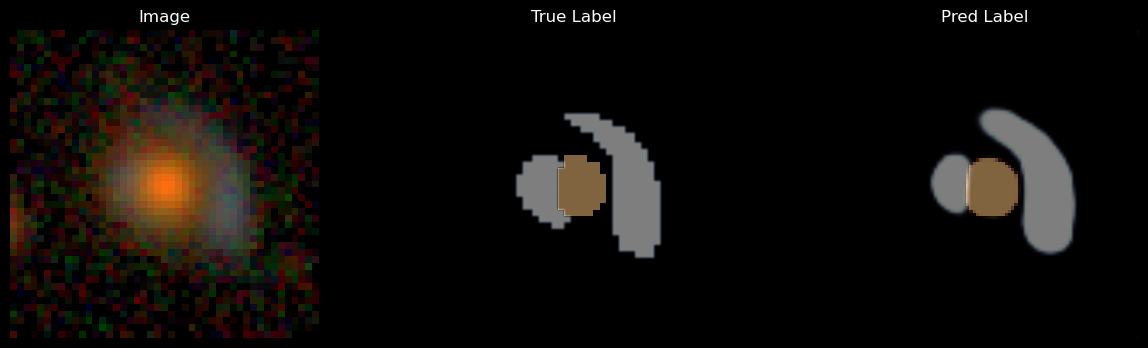

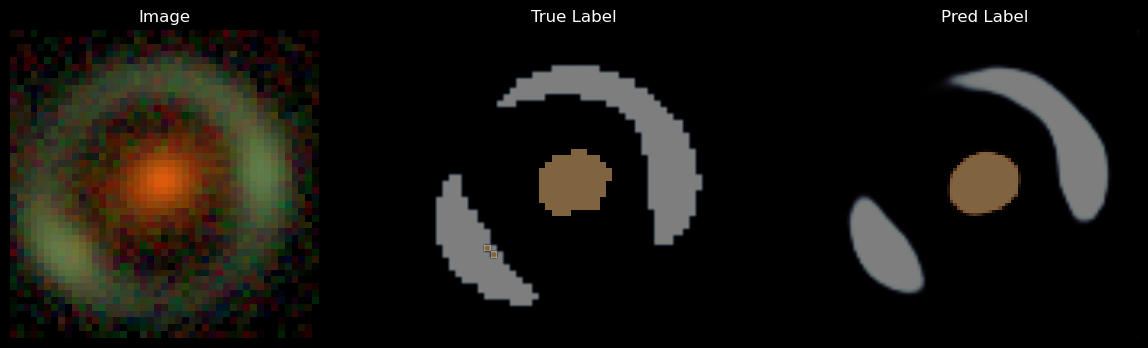

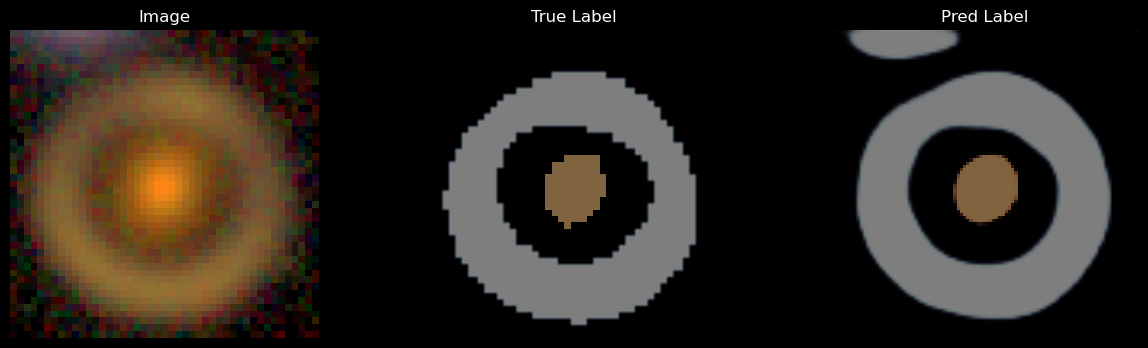

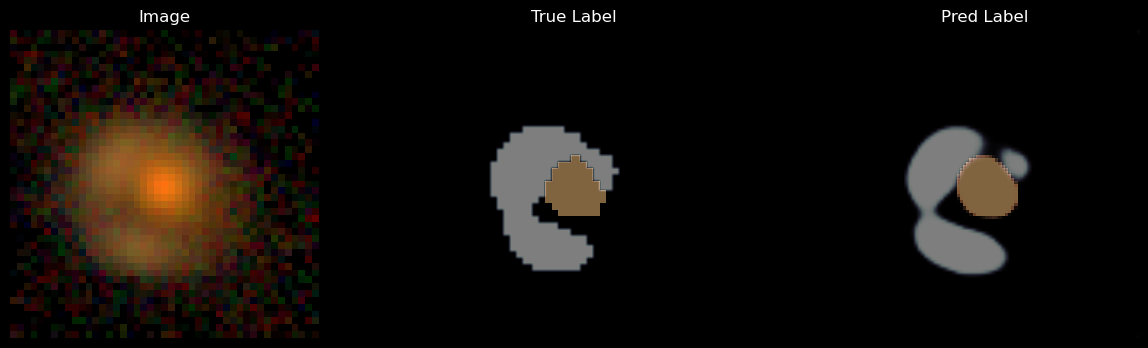

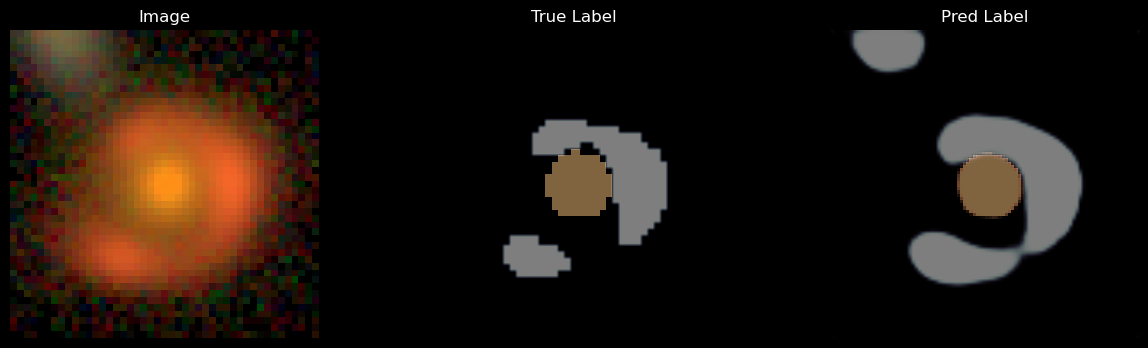

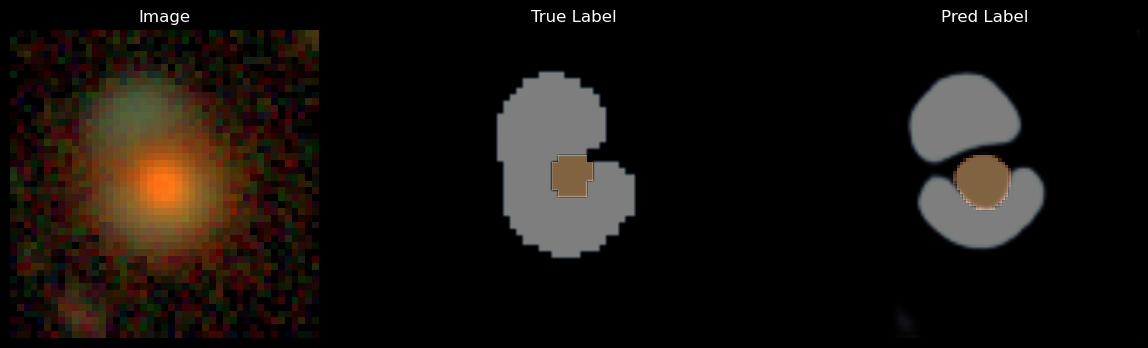

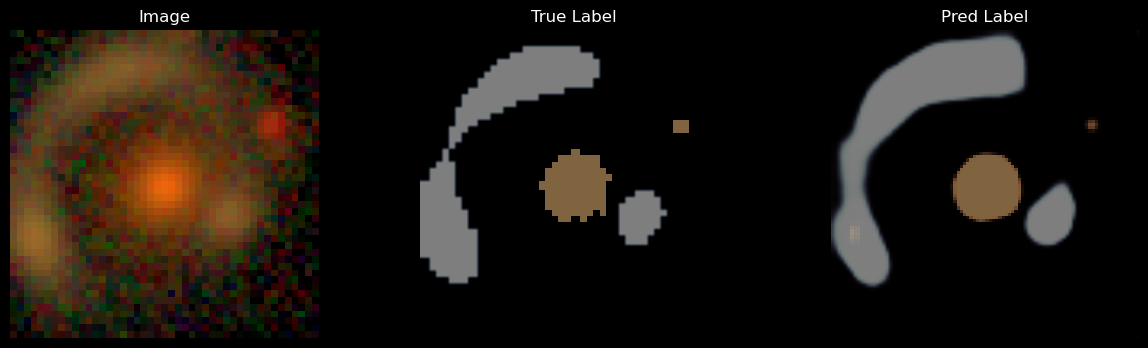

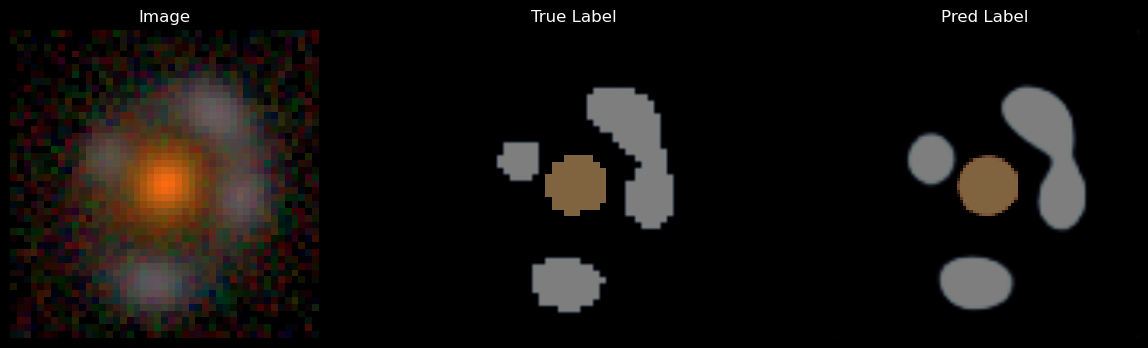

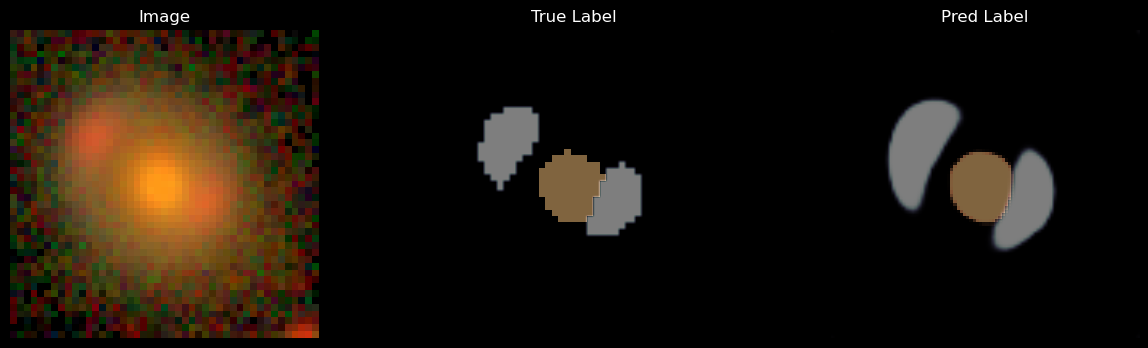

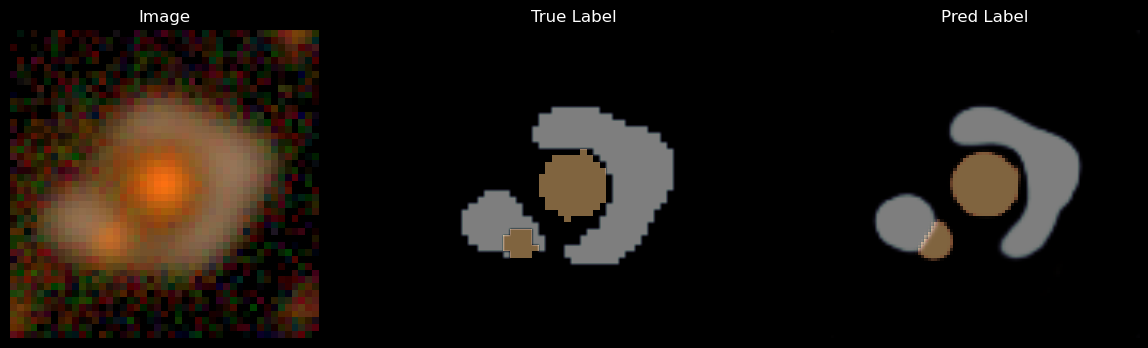

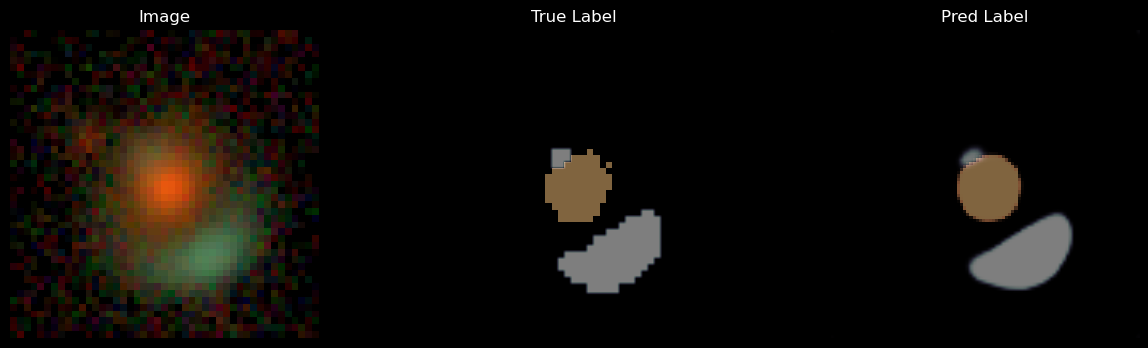

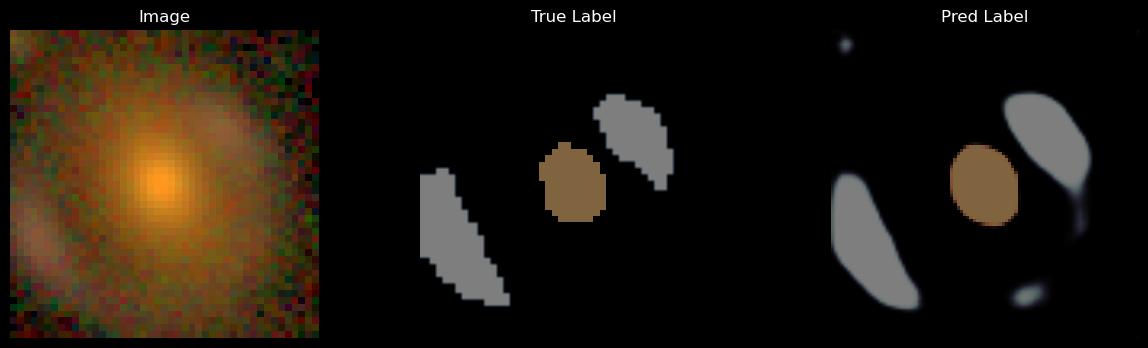

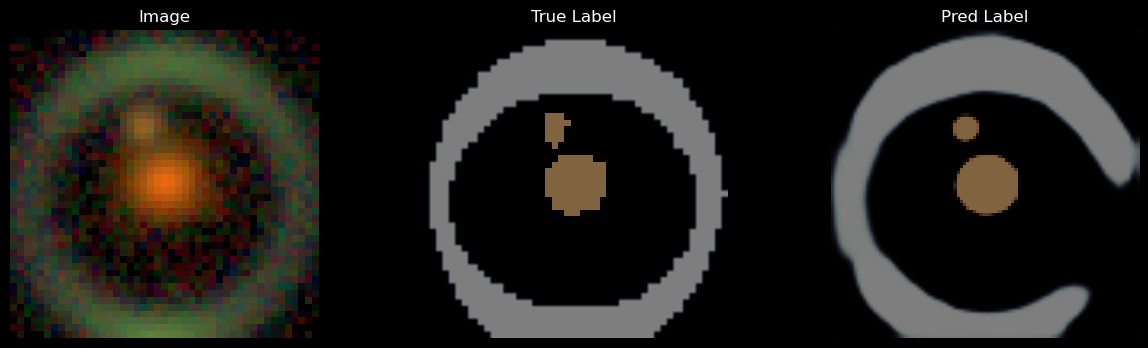

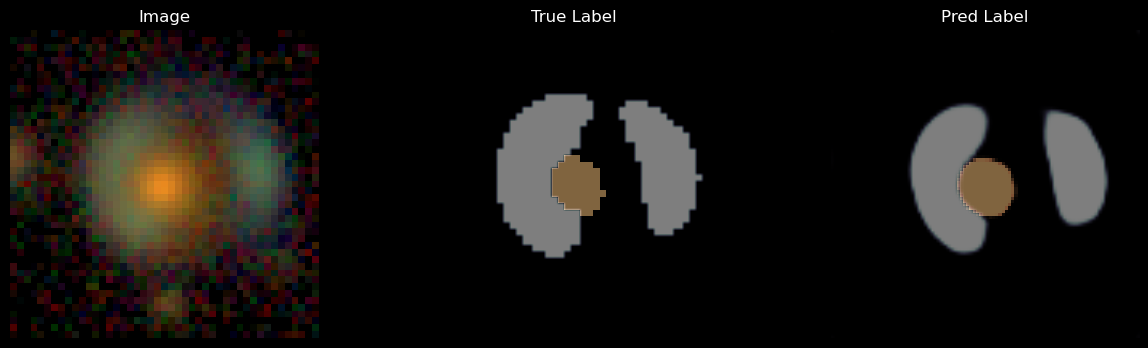

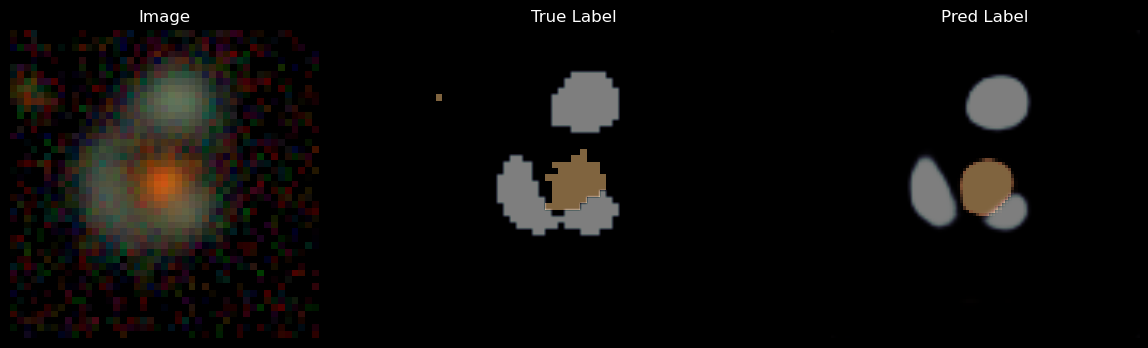

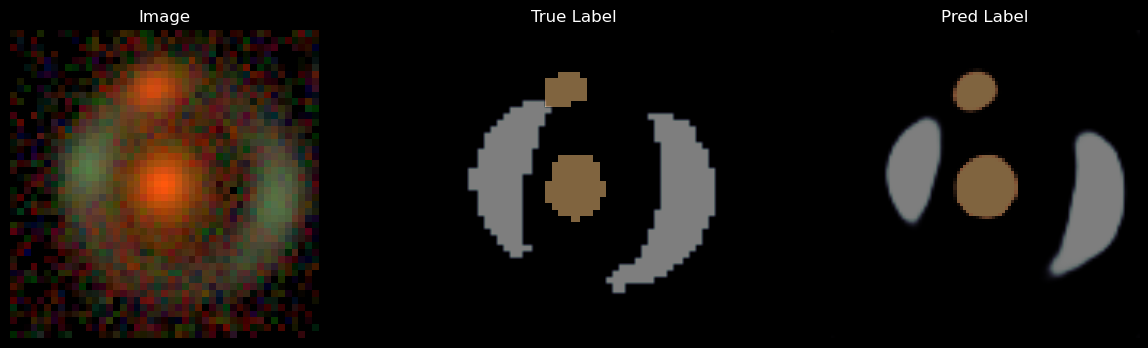

In [21]:
testing_analysis(0.5, test_loader)
plt.close('all')